<u><p style="font-size: 36px;font-weight: bold;font-style: oblique;text-indent: 30px;text-align: center;">**Household Electric Power Consumption Forecasting**</p></u>
<p style="text-indent:30px;font-size:16px"> The real energy demand made on the present electrical supply is referred to as electric energy consumption. However, poor management of its use can result in a reduction in electrical supply. As a result, it is critical that everyone be concerned about energy efficiency in order to reduce consumption. The goals of this study are to develop a model for <strong>forecasting household electricity usage</strong> and to determine the best forecasting period, which could be daily, weekly, monthly, or quarterly. Individual household electricity power usage is the time-series data in our investigation.This Notebook use Deep Learning and time-series data analysis methods for this aim.<br></p>
<p style="text-indent:30px;font-size:16px;">Any household requires electricity to function. In this period of global instability, the globe requires rising amounts of energy to maintain economic and social progress and improve living standards. Mishandling of electric energy could result in future excessive costs. Over 60% of residential energy in the United States is wasted. Many people who use power on a regular basis are unaware of how much energy is wasted. In this notebook series, I want to use and compare some of the following DeepLearning models: <strong>Prophet – Facebook, ARIMA (Autoregressive Integrated Moving Average), XGBoost/LightGBM, LSTM (Long Short Term Memory), DeepAR (Amazon time series model) and transformer(TFT,PatchTST,ETSformer,FEDformer) mentioned in link below and N-Beats, N-HITS are also mentioned in the timeseries interested community.</strong><p/>
    
["https://github.com/thuml/Time-Series-Library"](http://github.com/thuml/Time-Series-Library)

## ***About Dataset And Features:***

#### A detailed description of the dataset is given in the notebook, which is the first of this notebook series, and in the original location of the dataset on Kaggle.

## ***1.Importing Libraries***

In [2]:
# Let`s import all packages that we may need:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
from pandas.tseries.frequencies import to_offset

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # To simplify TensorFlow logs

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

## ***2.Reading Data***

In [3]:
df = pd.read_csv('/kaggle/input/data-to-model/df_before_modeling.csv',sep=',',
                 infer_datetime_format=True,
                 low_memory=False, index_col='dt')

In [4]:
df.index = pd.to_datetime(df.index)

In [5]:
df.head()

voltage  global_intensity  sub_metering_1  \
dt                                                               
2006-12-16 17:24:00   234.84              18.4             0.0   
2006-12-16 17:25:00   233.63              23.0             0.0   
2006-12-16 17:26:00   233.29              23.0             0.0   
2006-12-16 17:27:00   233.74              23.0             0.0   
2006-12-16 17:28:00   235.68              15.8             0.0   

                     sub_metering_2  sub_metering_3  power_factor  
dt                                                                 
2006-12-16 17:24:00             1.0            17.0      0.995121  
2006-12-16 17:25:00             1.0            16.0      0.996708  
2006-12-16 17:26:00             2.0            17.0      0.995734  
2006-12-16 17:27:00             1.0            17.0      0.995688  
2006-12-16 17:28:00             1.0            17.0      0.989787

## ***3.MODELING***

### ***3.1. Model Preparation***

In [5]:
df_hourly = df.resample("H").mean()

In [10]:
df_hourly.shape

(34589, 6)

In [11]:
df_hourly.head()

voltage  global_intensity  sub_metering_1  \
dt                                                                  
2006-12-16 17:00:00  234.643889         18.100000             0.0   
2006-12-16 18:00:00  234.580167         15.600000             0.0   
2006-12-16 19:00:00  233.232500         14.503333             0.0   
2006-12-16 20:00:00  234.071500         13.916667             0.0   
2006-12-16 21:00:00  237.158667         13.046667             0.0   

                     sub_metering_2  sub_metering_3  power_factor  
dt                                                                 
2006-12-16 17:00:00        0.527778       16.861111      0.997052  
2006-12-16 18:00:00        6.716667       16.866667      0.999518  
2006-12-16 19:00:00        1.433333       16.683333      0.999526  
2006-12-16 20:00:00        0.000000       16.783333      0.999569  
2006-12-16 21:00:00        0.416667       17.216667      0.999422

In [12]:
import numpy as np

def create_sequences(data, n_steps):
    """
    Creates sequences from time series data for LSTM/GRU model input.

    Parameters:
    -----------
    data : numpy array
        Input data with shape (samples, features).
        The last column is assumed to be the target variable.
    n_steps : int
        Number of time steps to look back (sequence length)

    Returns:
    --------
    X : numpy array
        Sequences with shape (samples, timesteps, features)
    y : numpy array
        Target values with shape (samples,)

    Example:
    --------
    # Assuming 'data' is your numpy array with shape (1000, 5)
    # where last column is your target variable
    X, y = create_sequences(data, n_steps=30)
    """
    X, y = [], []
    for i in range(len(data) - n_steps):
        sequence = data[i:(i + n_steps), :]
        target = data[i + n_steps, -1]  # Last column as target
        X.append(sequence)
        y.append(target)

    return np.array(X), np.array(y)

In [13]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
original_columns = df_hourly.columns.tolist()

# Data preprocessing
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_hourly.reset_index(drop=True))
df_scaled = pd.DataFrame(df_scaled, columns=df_hourly.columns, index=df_hourly.index)
df_scaled['Datetime'] = df_hourly.index
df_scaled.set_index('Datetime', inplace=True)

In [14]:
df_scaled.head(3)

voltage  global_intensity  sub_metering_1  \
Datetime                                                          
2006-12-16 17:00:00 -2.077988          3.607876       -0.319086   
2006-12-16 18:00:00 -2.099360          2.938368       -0.319086   
2006-12-16 19:00:00 -2.551344          2.644677       -0.319086   

                     sub_metering_2  sub_metering_3  power_factor  
Datetime                                                           
2006-12-16 17:00:00       -0.184969        1.424259      0.811481  
2006-12-16 18:00:00        1.300378        1.425020      0.872132  
2006-12-16 19:00:00        0.032366        1.399919      0.872329

In [15]:
# Train-test split
train_df = df_scaled.loc[df_scaled.index < '2010-01-01 00:00:00']
test_df = df_scaled.loc[df_scaled.index >= '2010-01-01 00:00:00']

target_col = 'power_factor'
feature_cols = train_df.columns.drop([target_col])

# Prepare data for LSTM
X_train_raw = train_df[feature_cols].values
y_train_raw = train_df[target_col].values
X_test_raw = test_df[feature_cols].values
y_test_raw = test_df[target_col].values

In [16]:
df_scaled.head(3)

voltage  global_intensity  sub_metering_1  \
Datetime                                                          
2006-12-16 17:00:00 -2.077988          3.607876       -0.319086   
2006-12-16 18:00:00 -2.099360          2.938368       -0.319086   
2006-12-16 19:00:00 -2.551344          2.644677       -0.319086   

                     sub_metering_2  sub_metering_3  power_factor  
Datetime                                                           
2006-12-16 17:00:00       -0.184969        1.424259      0.811481  
2006-12-16 18:00:00        1.300378        1.425020      0.872132  
2006-12-16 19:00:00        0.032366        1.399919      0.872329

In [17]:
train_df.head(3)

voltage  global_intensity  sub_metering_1  \
Datetime                                                          
2006-12-16 17:00:00 -2.077988          3.607876       -0.319086   
2006-12-16 18:00:00 -2.099360          2.938368       -0.319086   
2006-12-16 19:00:00 -2.551344          2.644677       -0.319086   

                     sub_metering_2  sub_metering_3  power_factor  
Datetime                                                           
2006-12-16 17:00:00       -0.184969        1.424259      0.811481  
2006-12-16 18:00:00        1.300378        1.425020      0.872132  
2006-12-16 19:00:00        0.032366        1.399919      0.872329

In [18]:
train_df.tail(3)

voltage  global_intensity  sub_metering_1  \
Datetime                                                          
2009-12-31 21:00:00 -1.408023          2.001056       -0.319086   
2009-12-31 22:00:00 -0.981304          1.042320       -0.319086   
2009-12-31 23:00:00 -0.257716          0.623654       -0.319086   

                     sub_metering_2  sub_metering_3  power_factor  
Datetime                                                           
2009-12-31 21:00:00       -0.227636        1.678307      0.805964  
2009-12-31 22:00:00       -0.183636        1.577905      0.795738  
2009-12-31 23:00:00       -0.311637        1.623542      0.809150

In [19]:
test_df.head(3)

voltage  global_intensity  sub_metering_1  \
Datetime                                                          
2010-01-01 00:00:00  0.154358         -0.040499       -0.319086   
2010-01-01 01:00:00  0.261905         -0.510047       -0.319086   
2010-01-01 02:00:00  1.064029         -0.528794       -0.319086   

                     sub_metering_2  sub_metering_3  power_factor  
Datetime                                                           
2010-01-01 00:00:00       -0.311637        0.281803      0.628644  
2010-01-01 01:00:00       -0.119635       -0.795239      0.188649  
2010-01-01 02:00:00       -0.311637       -0.792957      0.429025

In [20]:
test_df.tail(3)

voltage  global_intensity  sub_metering_1  \
Datetime                                                          
2010-11-26 19:00:00 -1.374653          0.650434       -0.319086   
2010-11-26 20:00:00 -0.484211          0.076442       -0.319086   
2010-11-26 21:00:00 -0.385608         -0.221712       -0.319086   

                     sub_metering_2  sub_metering_3  power_factor  
Datetime                                                           
2010-11-26 19:00:00       -0.295637       -0.884232      0.852165  
2010-11-26 20:00:00       -0.055635       -0.884232      0.814536  
2010-11-26 21:00:00       -0.311637       -0.884232      0.883997

### ***3.2.Model Selection¶***
#### ***3.2.1.LSTM(Long Short Term Memory)***


LSTM (Long Short-Term Memory) is a special type of RNN (Recurrent Neural Network) designed for sequential data problems such as time series forecasting, natural language processing (NLP), and speech recognition.<br>

 Why LSTM?<br><br>

- Can learn both short-term and long-term dependencies <br>
- Solves the Vanishing Gradient problem <br>
- Stores past information for a long time using memory cells <br><br>
 Key Components of LSTM<br><br>
LSTM consists of three main gates:<br>

- Forget Gate: Deletes unnecessary information.<br>
- Input Gate: Adds new information to memory.<br>
- Output Gate: Outputs the updated information.<br><br>
 Applications of LSTM<br><br>

- Time Series Forecasting (Finance, weather, energy demand prediction)<br>
- Natural Language Processing (NLP) (Text prediction, translation, chatbots)<br>
- Speech and Voice Recognition<br>
- Medical Data Analysis

Epoch 1/10
417/417 - 4s - 10ms/step - loss: 0.5636 - mean_absolute_error: 0.5943 - val_loss: 0.5470 - val_mean_absolute_error: 0.5722
Epoch 2/10
417/417 - 2s - 5ms/step - loss: 0.4786 - mean_absolute_error: 0.5214 - val_loss: 0.4945 - val_mean_absolute_error: 0.5186
Epoch 3/10
417/417 - 2s - 4ms/step - loss: 0.4594 - mean_absolute_error: 0.5038 - val_loss: 0.4790 - val_mean_absolute_error: 0.5056
Epoch 4/10
417/417 - 2s - 4ms/step - loss: 0.4482 - mean_absolute_error: 0.4938 - val_loss: 0.4731 - val_mean_absolute_error: 0.5035
Epoch 5/10
417/417 - 2s - 4ms/step - loss: 0.4385 - mean_absolute_error: 0.4862 - val_loss: 0.4681 - val_mean_absolute_error: 0.4996
Epoch 6/10
417/417 - 2s - 5ms/step - loss: 0.4292 - mean_absolute_error: 0.4790 - val_loss: 0.4612 - val_mean_absolute_error: 0.4952
Epoch 7/10
417/417 - 2s - 4ms/step - loss: 0.4210 - mean_absolute_error: 0.4712 - val_loss: 0.4559 - val_mean_absolute_error: 0.4900
Epoch 8/10
417/417 - 2s - 4ms/step - loss: 0.4132 - mean_absolute_er

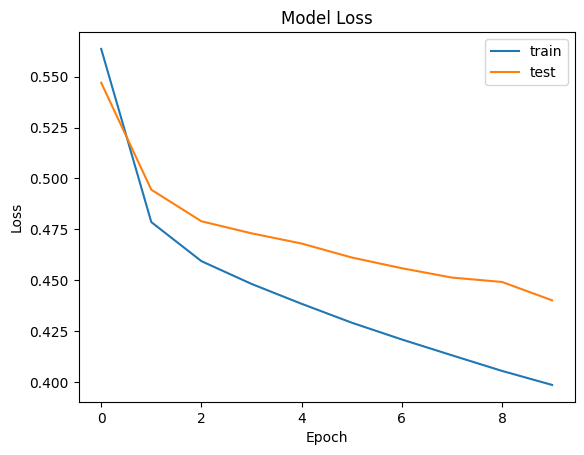

247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
inv_y shape: (7888,)
inv_yhat shape: (7888,)
Test MAPE: 1.994%
Test RMSE: 0.027


In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Create sequences for LSTM
n_steps = 30
X_train, y_train = create_sequences(np.column_stack((y_train_raw, X_train_raw)), n_steps)
X_test, y_test = create_sequences(np.column_stack((y_test_raw, X_test_raw)), n_steps)

# Create the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=100, activation='tanh',
                   input_shape=(n_steps, X_train.shape[2]),
                   return_sequences=False))
model_lstm.add(Dense(1))

# Compile the model
model_lstm.compile(optimizer=Adam(learning_rate=0.001),
                  loss="mean_squared_error",
                  metrics=['mean_absolute_error'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',
                             patience=10,
                             restore_best_weights=True)

# Train the model
history_lstm = model_lstm.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=64,
    verbose=2,
    shuffle=False,
    callbacks=[early_stopping]
)

# Plot training history
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# Make predictions
yhat = model_lstm.predict(X_test)

# Ensure the predicted values and test values have the same length
yhat = yhat.flatten()  # Convert to 1D array
y_test = y_test.flatten()

# ** Fix the inverse transform issue **

# Create an empty array for inverse transformation
dummy_data = np.zeros((len(yhat), len(original_columns)))

# Assign predicted values to the correct column index
target_index = list(original_columns).index(target_col)
dummy_data[:, target_index] = yhat

# Inverse transform using the original scaler
inv_yhat = scaler.inverse_transform(dummy_data)[:, target_index]

# Do the same for actual values
dummy_data[:, target_index] = y_test
inv_y = scaler.inverse_transform(dummy_data)[:, target_index]

# Check for shape consistency before computing metrics
print("inv_y shape:", inv_y.shape)
print("inv_yhat shape:", inv_yhat.shape)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
mape = np.mean(np.abs((inv_y - inv_yhat) / inv_y)) * 100

print('Test MAPE: %.3f%%' % mape)
print('Test RMSE: %.3f' % rmse)

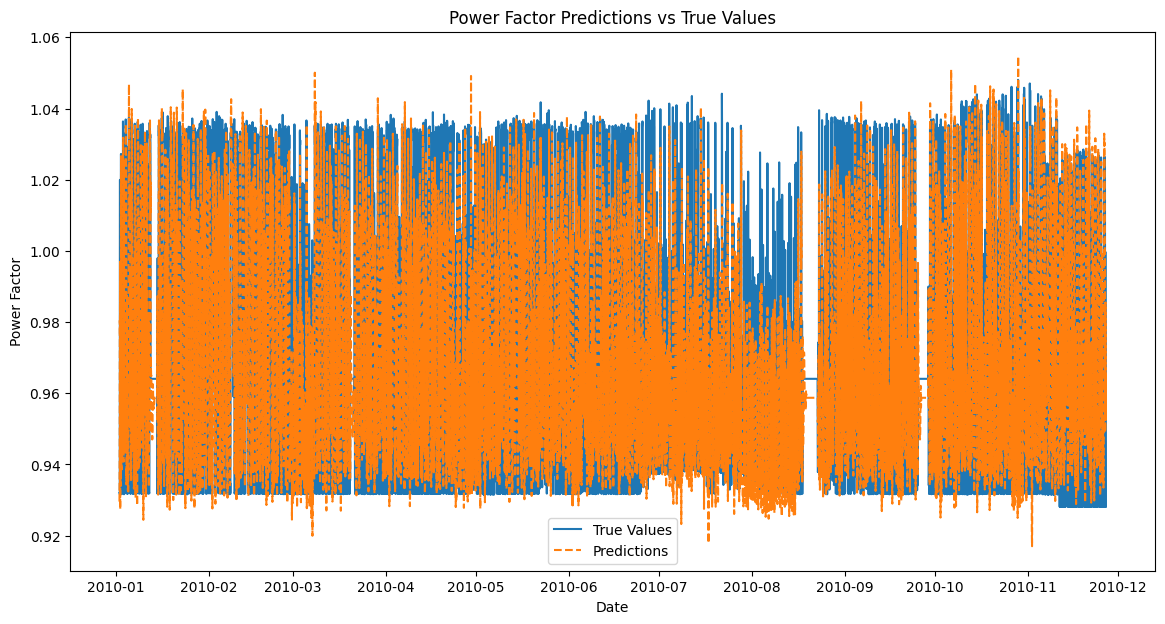

In [22]:
# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(df_hourly.index[-len(inv_y):], inv_y, label='True Values')
plt.plot(df_hourly.index[-len(inv_y):], inv_yhat, label='Predictions', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Power Factor')
plt.title('Power Factor Predictions vs True Values')
plt.legend()
plt.show()

In [23]:
model_lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 100)                 │          42,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 128,705 (502.76 KB)

 Trainable params: 42,901 (167.58 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 85,804 (335.18 KB)

Epoch 1/20
833/833 - 7s - 8ms/step - loss: 0.5088 - mean_absolute_error: 0.5407 - val_loss: 0.5283 - val_mean_absolute_error: 0.5299
Epoch 2/20
833/833 - 5s - 6ms/step - loss: 0.4435 - mean_absolute_error: 0.4884 - val_loss: 0.4773 - val_mean_absolute_error: 0.4912
Epoch 3/20
833/833 - 5s - 6ms/step - loss: 0.4168 - mean_absolute_error: 0.4647 - val_loss: 0.4338 - val_mean_absolute_error: 0.4647
Epoch 4/20
833/833 - 5s - 6ms/step - loss: 0.3866 - mean_absolute_error: 0.4376 - val_loss: 0.4224 - val_mean_absolute_error: 0.4678
Epoch 5/20
833/833 - 5s - 6ms/step - loss: 0.3674 - mean_absolute_error: 0.4215 - val_loss: 0.4222 - val_mean_absolute_error: 0.4547
Epoch 6/20
833/833 - 5s - 6ms/step - loss: 0.3514 - mean_absolute_error: 0.4083 - val_loss: 0.4253 - val_mean_absolute_error: 0.4415
Epoch 7/20
833/833 - 5s - 6ms/step - loss: 0.3405 - mean_absolute_error: 0.3991 - val_loss: 0.4279 - val_mean_absolute_error: 0.4480
Epoch 8/20
833/833 - 5s - 6ms/step - loss: 0.3281 - mean_absolute_err

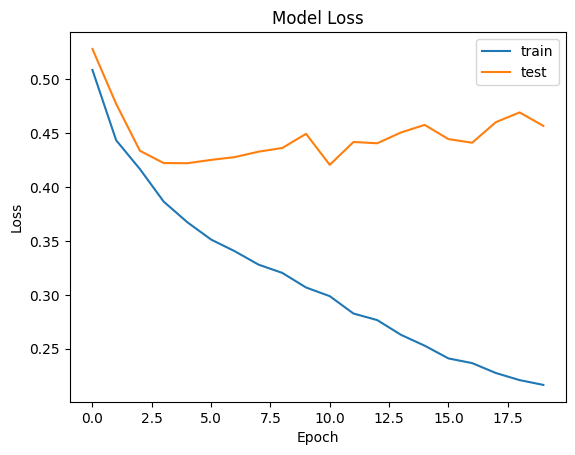

247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
inv_y shape: (7894,)
inv_yhat shape: (7894,)
Test MAPE: 1.789%
Test RMSE: 0.026


In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense
from tensorflow.keras.optimizers import Adam

# Create sequences for LSTM
n_steps = 24
X_train, y_train = create_sequences(np.column_stack((y_train_raw, X_train_raw)), n_steps)
X_test, y_test = create_sequences(np.column_stack((y_test_raw, X_test_raw)), n_steps)

# Create the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=100, activation='tanh',
                   input_shape=(n_steps, X_train.shape[2]),
                   return_sequences=True))
model_lstm.add(LSTM(units=50,activation='tanh',
                   return_sequences=False))
model_lstm.add(Dense(1))

# Compile the model
model_lstm.compile(optimizer=Adam(learning_rate=0.005),
                  loss="mean_squared_error",
                  metrics=['mean_absolute_error'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',
                             patience=10,
                             restore_best_weights=True)

# Train the model
history_lstm = model_lstm.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32,
    verbose=2,
    shuffle=False,
    callbacks=[early_stopping]
)

# Plot training history
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# Make predictions
yhat = model_lstm.predict(X_test)

# Ensure the predicted values and test values have the same length
yhat = yhat.flatten()  # Convert to 1D array
y_test = y_test.flatten()

# ** Fix the inverse transform issue **

# Create an empty array for inverse transformation
dummy_data = np.zeros((len(yhat), len(original_columns)))

# Assign predicted values to the correct column index
target_index = list(original_columns).index(target_col)
dummy_data[:, target_index] = yhat

# Inverse transform using the original scaler
inv_yhat = scaler.inverse_transform(dummy_data)[:, target_index]

# Do the same for actual values
dummy_data[:, target_index] = y_test
inv_y = scaler.inverse_transform(dummy_data)[:, target_index]

# Check for shape consistency before computing metrics
print("inv_y shape:", inv_y.shape)
print("inv_yhat shape:", inv_yhat.shape)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
mape = np.mean(np.abs((inv_y - inv_yhat) / inv_y)) * 100

print('Test MAPE: %.3f%%' % mape)
print('Test RMSE: %.3f' % rmse)

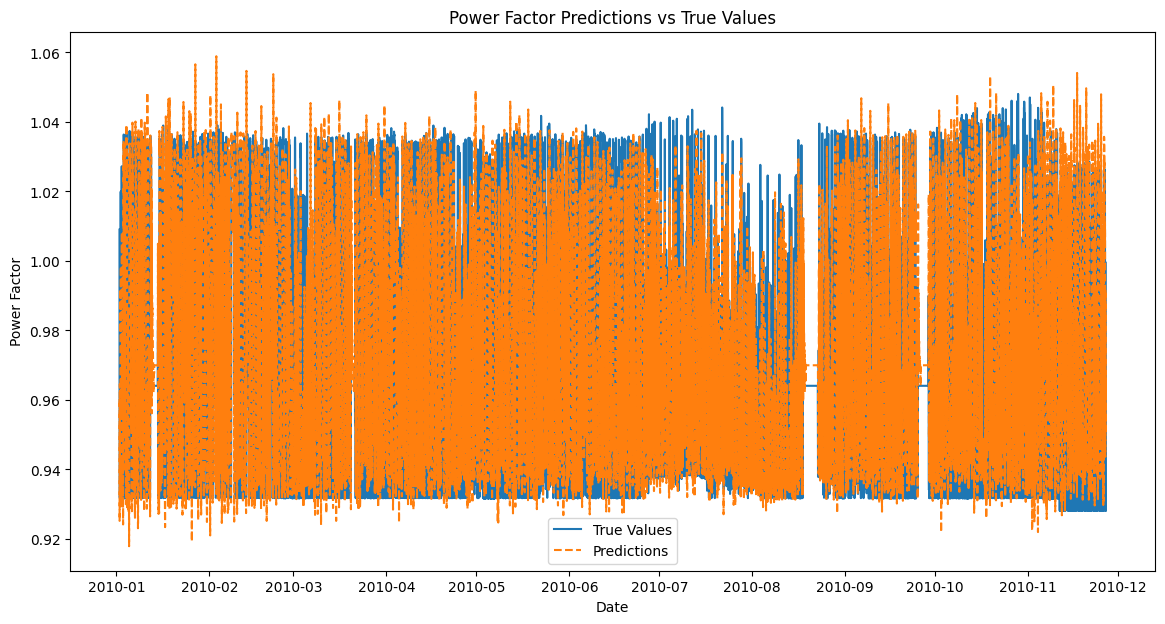

In [25]:
# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(df_hourly.index[-len(inv_y):], inv_y, label='True Values')
plt.plot(df_hourly.index[-len(inv_y):], inv_yhat, label='Predictions', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Power Factor')
plt.title('Power Factor Predictions vs True Values')
plt.legend()
plt.show()

Epoch 1/10
417/417 - 3s - 7ms/step - loss: 0.5596 - mean_absolute_error: 0.5903 - val_loss: 0.5357 - val_mean_absolute_error: 0.5639
Epoch 2/10
417/417 - 2s - 4ms/step - loss: 0.4808 - mean_absolute_error: 0.5239 - val_loss: 0.4947 - val_mean_absolute_error: 0.5177
Epoch 3/10
417/417 - 2s - 4ms/step - loss: 0.4617 - mean_absolute_error: 0.5068 - val_loss: 0.4763 - val_mean_absolute_error: 0.5045
Epoch 4/10
417/417 - 2s - 4ms/step - loss: 0.4489 - mean_absolute_error: 0.4947 - val_loss: 0.4682 - val_mean_absolute_error: 0.5005
Epoch 5/10
417/417 - 2s - 4ms/step - loss: 0.4381 - mean_absolute_error: 0.4856 - val_loss: 0.4614 - val_mean_absolute_error: 0.4957
Epoch 6/10
417/417 - 2s - 4ms/step - loss: 0.4272 - mean_absolute_error: 0.4764 - val_loss: 0.4625 - val_mean_absolute_error: 0.4971
Epoch 7/10
417/417 - 2s - 4ms/step - loss: 0.4206 - mean_absolute_error: 0.4698 - val_loss: 0.4504 - val_mean_absolute_error: 0.4899
Epoch 8/10
417/417 - 2s - 4ms/step - loss: 0.4122 - mean_absolute_err

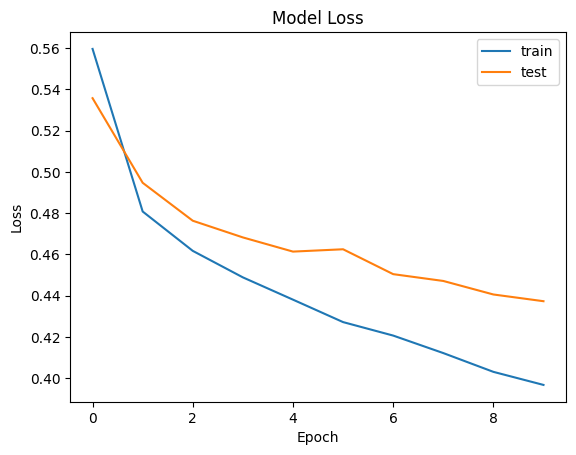

247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
inv_y shape: (7888,)
inv_yhat shape: (7888,)
Test MAPE: 1.987%
Test RMSE: 0.027


In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense
from tensorflow.keras.optimizers import Adam
# Create sequences for LSTM
n_steps = 30
X_train, y_train = create_sequences(np.column_stack((y_train_raw, X_train_raw)), n_steps)
X_test, y_test = create_sequences(np.column_stack((y_test_raw, X_test_raw)), n_steps)

# Create the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=100, activation='tanh',
                   input_shape=(n_steps, X_train.shape[2]),
                   return_sequences=False))
model_lstm.add(Dense(1))

# Compile the model
model_lstm.compile(optimizer=Adam(learning_rate=0.001),
                  loss="mean_squared_error",
                  metrics=['mean_absolute_error'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',
                             patience=10,
                             restore_best_weights=True)

# Train the model
history_lstm = model_lstm.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=64,
    verbose=2,
    shuffle=False,
    callbacks=[early_stopping]
)

# Plot training history
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# Make predictions
yhat = model_lstm.predict(X_test)

# Ensure the predicted values and test values have the same length
yhat = yhat.flatten()  # Convert to 1D array
y_test = y_test.flatten()

# ** Fix the inverse transform issue **

# Create an empty array for inverse transformation
dummy_data = np.zeros((len(yhat), len(original_columns)))

# Assign predicted values to the correct column index
target_index = list(original_columns).index(target_col)
dummy_data[:, target_index] = yhat

# Inverse transform using the original scaler
inv_yhat = scaler.inverse_transform(dummy_data)[:, target_index]

# Do the same for actual values
dummy_data[:, target_index] = y_test
inv_y = scaler.inverse_transform(dummy_data)[:, target_index]

# Check for shape consistency before computing metrics
print("inv_y shape:", inv_y.shape)
print("inv_yhat shape:", inv_yhat.shape)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
mape = np.mean(np.abs((inv_y - inv_yhat) / inv_y)) * 100

print('Test MAPE: %.3f%%' % mape)
print('Test RMSE: %.3f' % rmse)

In [27]:
# Create a DataFrame containing actual and predicted values
diff = inv_y-inv_yhat
results_df = pd.DataFrame({
    'Datetime': test_df.index[n_steps:],
    'Actual': inv_y,
    'Predicted': inv_yhat,
    'Error' : diff
})


print(results_df.sample(15))

                Datetime    Actual  Predicted     Error
7718 2010-11-19 20:00:00  0.928116   0.964100 -0.035984
917  2010-02-09 11:00:00  1.033683   0.991399  0.042284
1641 2010-03-11 15:00:00  0.940732   0.996176 -0.055444
4241 2010-06-27 23:00:00  0.937300   0.985950 -0.048651
4178 2010-06-25 08:00:00  1.010770   1.019984 -0.009215
3609 2010-06-01 15:00:00  1.035445   0.993772  0.041673
454  2010-01-21 04:00:00  0.931919   0.927224  0.004695
1851 2010-03-20 09:00:00  0.964063   0.973562 -0.009499
1892 2010-03-22 02:00:00  0.987207   0.946935  0.040272
1506 2010-03-06 00:00:00  0.931734   0.944691 -0.012957
6828 2010-10-13 18:00:00  0.954740   1.018182 -0.063442
1907 2010-03-22 17:00:00  0.931827   0.979440 -0.047614
7504 2010-11-10 22:00:00  0.934238   0.948591 -0.014352
2553 2010-04-18 15:00:00  1.002699   0.999073  0.003626
3618 2010-06-02 00:00:00  0.936465   0.978760 -0.042296


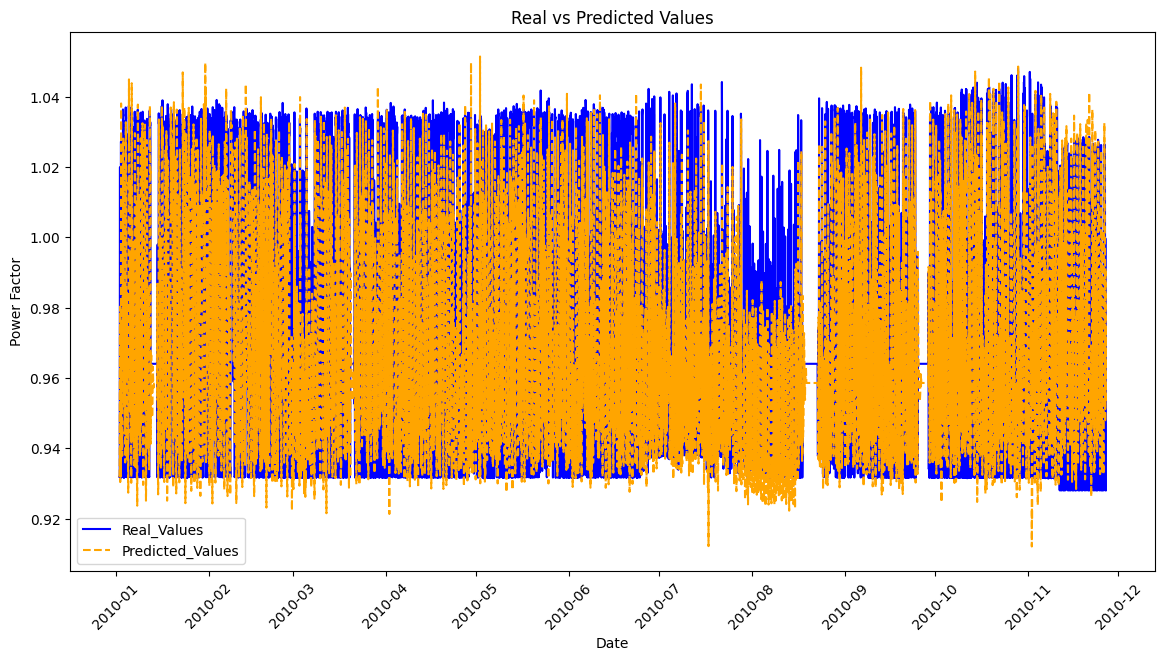

In [28]:
plt.figure(figsize=(14, 7))
plt.plot(results_df['Datetime'], results_df['Actual'], label='Real_Values', color='blue')
plt.plot(results_df['Datetime'], results_df['Predicted'], label='Predicted_Values', linestyle='dashed', color='orange')

plt.xlabel('Date')
plt.ylabel('Power Factor')
plt.title('Real vs Predicted Values')
plt.legend()
plt.xticks(rotation=45)
plt.show()

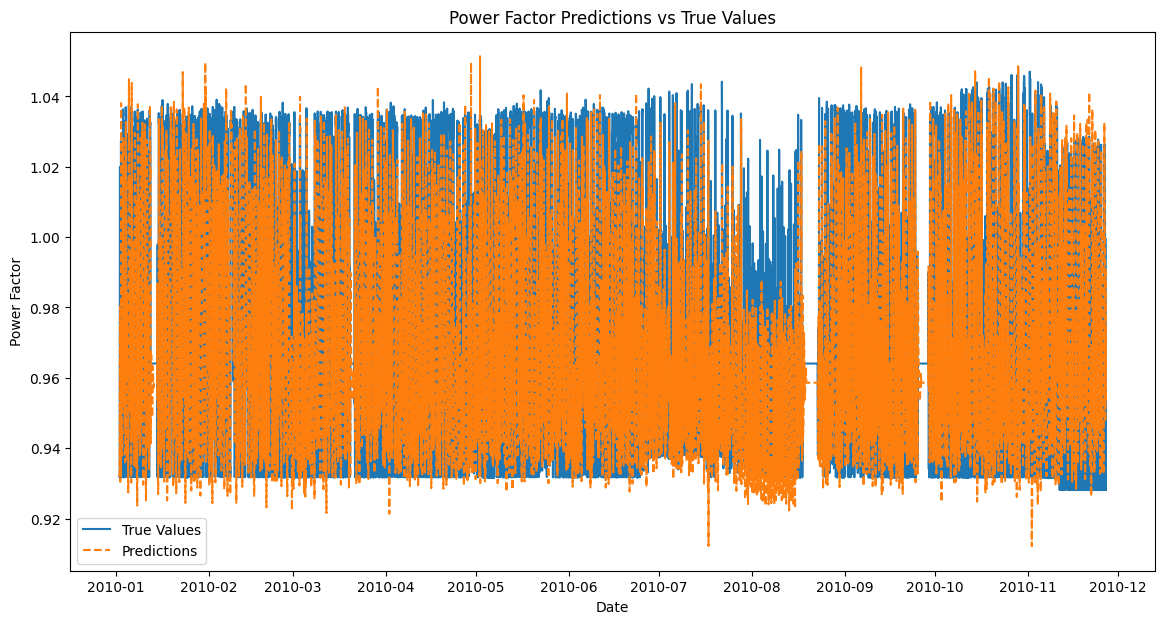

In [29]:
# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(df_hourly.index[-len(inv_y):], inv_y, label='True Values')
plt.plot(df_hourly.index[-len(inv_y):], inv_yhat, label='Predictions', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Power Factor')
plt.title('Power Factor Predictions vs True Values')
plt.legend()
plt.show()

In [30]:
model_lstm.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 100)                 │          42,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 128,705 (502.76 KB)

 Trainable params: 42,901 (167.58 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 85,804 (335.18 KB)

Epoch 1/20
1666/1666 - 19s - 11ms/step - loss: 0.4893 - mean_absolute_error: 0.5228 - val_loss: 0.4897 - val_mean_absolute_error: 0.4999
Epoch 2/20
1666/1666 - 16s - 9ms/step - loss: 0.4184 - mean_absolute_error: 0.4631 - val_loss: 0.4429 - val_mean_absolute_error: 0.4686
Epoch 3/20
1666/1666 - 15s - 9ms/step - loss: 0.3880 - mean_absolute_error: 0.4383 - val_loss: 0.4538 - val_mean_absolute_error: 0.4533
Epoch 4/20
1666/1666 - 16s - 9ms/step - loss: 0.3714 - mean_absolute_error: 0.4238 - val_loss: 0.4643 - val_mean_absolute_error: 0.4534
Epoch 5/20
1666/1666 - 16s - 10ms/step - loss: 0.3583 - mean_absolute_error: 0.4115 - val_loss: 0.4572 - val_mean_absolute_error: 0.4494
Epoch 6/20
1666/1666 - 16s - 9ms/step - loss: 0.3470 - mean_absolute_error: 0.4035 - val_loss: 0.4639 - val_mean_absolute_error: 0.4699
Epoch 7/20
1666/1666 - 16s - 9ms/step - loss: 0.3380 - mean_absolute_error: 0.3956 - val_loss: 0.4580 - val_mean_absolute_error: 0.4645
Epoch 8/20
1666/1666 - 16s - 9ms/step - loss: 

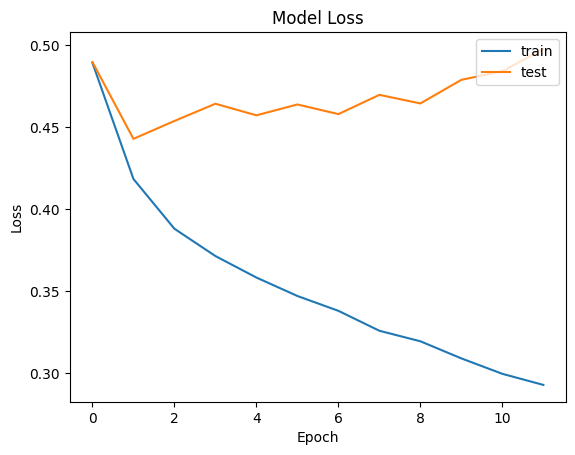

247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
inv_y shape: (7894,)
inv_yhat shape: (7894,)
Test MAPE: 1.960%
Test RMSE: 0.027


In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense
from tensorflow.keras.optimizers import Adam

# Create sequences for LSTM
n_steps = 24
X_train, y_train = create_sequences(np.column_stack((y_train_raw, X_train_raw)), n_steps)
X_test, y_test = create_sequences(np.column_stack((y_test_raw, X_test_raw)), n_steps)

# Create the LSTM model
model_bilstm = Sequential()
model_bilstm.add(Bidirectional(LSTM(units=128, activation='tanh',
                   input_shape=(n_steps, X_train.shape[2]),
                   return_sequences=True)))
model_bilstm.add(Bidirectional(LSTM(units=64, activation='tanh',
                   return_sequences=False)))
model_bilstm.add(Dense(1))

# Compile the model
model_bilstm.compile(optimizer=Adam(learning_rate=0.005),
                  loss="mean_squared_error",
                  metrics=['mean_absolute_error'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',
                             patience=10,
                             restore_best_weights=True)

# Train the model
history_bilstm = model_bilstm.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=16,
    verbose=2,
    shuffle=False,
    callbacks=[early_stopping]
)

# Plot training history
plt.plot(history_bilstm.history['loss'])
plt.plot(history_bilstm.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# Make predictions
yhat = model_bilstm.predict(X_test)

# Ensure the predicted values and test values have the same length
yhat = yhat.flatten()  # Convert to 1D array
y_test = y_test.flatten()

# ** Fix the inverse transform issue **

# Create an empty array for inverse transformation
dummy_data = np.zeros((len(yhat), len(original_columns)))

# Assign predicted values to the correct column index
target_index = list(original_columns).index(target_col)
dummy_data[:, target_index] = yhat

# Inverse transform using the original scaler
inv_yhat = scaler.inverse_transform(dummy_data)[:, target_index]

# Do the same for actual values
dummy_data[:, target_index] = y_test
inv_y = scaler.inverse_transform(dummy_data)[:, target_index]

# Check for shape consistency before computing metrics
print("inv_y shape:", inv_y.shape)
print("inv_yhat shape:", inv_yhat.shape)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
mape = np.mean(np.abs((inv_y - inv_yhat) / inv_y)) * 100

print('Test MAPE: %.3f%%' % mape)
print('Test RMSE: %.3f' % rmse)

In [32]:
model_bilstm.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 24, 256)             │         138,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 908,165 (3.46 MB)

 Trainable params: 302,721 (1.15 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 605,444 (2.31 MB)

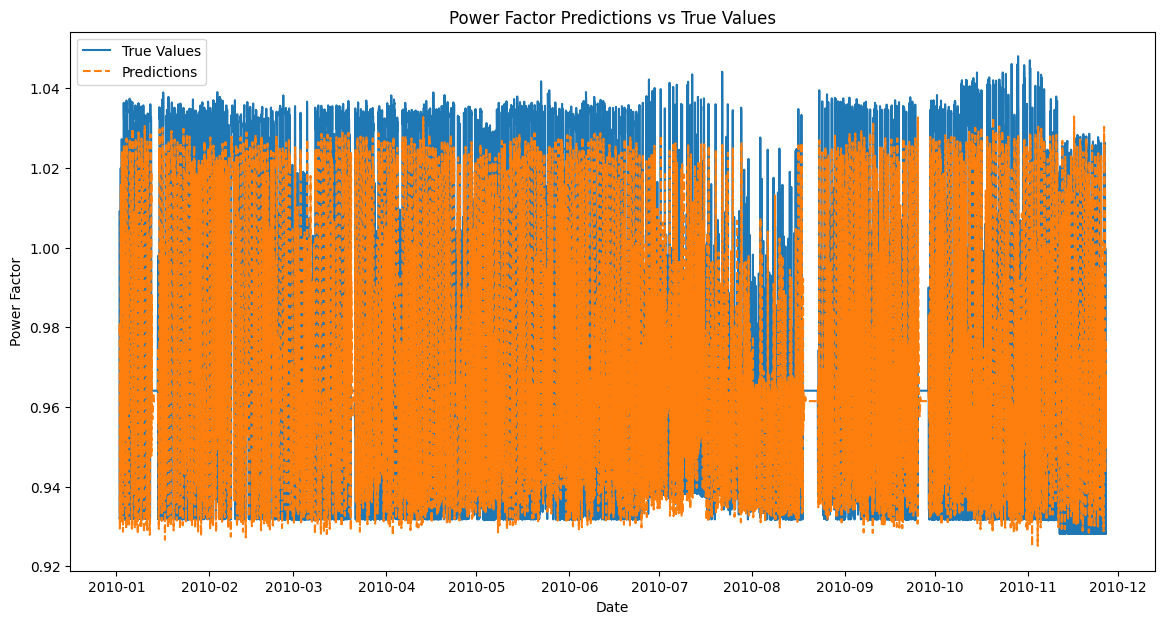

In [33]:
# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(df_hourly.index[-len(inv_y):], inv_y, label='True Values')
plt.plot(df_hourly.index[-len(inv_y):], inv_yhat, label='Predictions', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Power Factor')
plt.title('Power Factor Predictions vs True Values')
plt.legend()
plt.show()

In [34]:
# Create a DataFrame containing actual and predicted values
diff = inv_y-inv_yhat
results_df = pd.DataFrame({
    'Datetime': test_df.index[n_steps:],
    'Actual': inv_y,
    'Predicted': inv_yhat,
    'Error' : diff
})


print(results_df.sample(15))

                Datetime    Actual  Predicted     Error
4979 2010-07-28 11:00:00  0.937207   0.933510  0.003697
6690 2010-10-07 18:00:00  0.937114   0.933258  0.003856
2066 2010-03-29 02:00:00  0.931827   0.934279 -0.002452
7633 2010-11-16 01:00:00  0.928116   0.938387 -0.010271
1440 2010-03-03 00:00:00  0.934981   0.948465 -0.013484
7401 2010-11-06 09:00:00  1.020881   1.026817 -0.005936
7652 2010-11-16 20:00:00  0.962625   0.961619  0.001005
6270 2010-09-20 06:00:00  0.958636   0.937138  0.021497
7487 2010-11-09 23:00:00  0.968283   1.013293 -0.045009
5986 2010-09-08 10:00:00  0.941196   1.019954 -0.078758
1681 2010-03-13 01:00:00  0.931827   0.931965 -0.000138
2542 2010-04-17 22:00:00  0.935537   0.933369  0.002168
611  2010-01-27 11:00:00  1.032848   1.017235  0.015613
4014 2010-06-18 06:00:00  0.937021   0.944108 -0.007087
5441 2010-08-16 17:00:00  0.968747   0.951486  0.017261


###   **The results don't look bad but**<br>

In the loss graph, the blue line shows training loss, while the orange line shows test loss.
Loss values start at approximately 0.46 and decrease to around 0.025 over time, indicating that the model is learning.
There are several possible reasons for the fluctuating test loss:

- Noise in the dataset
- Learning rate might be a bit high
- Small batch size
- Model's tendency to overfit in some periods

Prediction vs True Values Graph Analysis:

- The blue line shows actual power factor values, while orange dots represent prediction.Predictions generally track the true values quite well (in the 0.95-1.00 range). More deviation is observed particularly during the 2010-07 and 2010-08 periods
The model can't fully capture sudden drops (spikes), which is normal as predicting such sudden changes is difficult

Epoch 1/20
417/417 - 7s - 17ms/step - loss: 0.5254 - mean_absolute_error: 0.5542 - val_loss: 0.5531 - val_mean_absolute_error: 0.5579
Epoch 2/20
417/417 - 4s - 10ms/step - loss: 0.4606 - mean_absolute_error: 0.5035 - val_loss: 0.5283 - val_mean_absolute_error: 0.5198
Epoch 3/20
417/417 - 4s - 10ms/step - loss: 0.4329 - mean_absolute_error: 0.4773 - val_loss: 0.4626 - val_mean_absolute_error: 0.4688
Epoch 4/20
417/417 - 4s - 10ms/step - loss: 0.4072 - mean_absolute_error: 0.4553 - val_loss: 0.4333 - val_mean_absolute_error: 0.4496
Epoch 5/20
417/417 - 4s - 10ms/step - loss: 0.3838 - mean_absolute_error: 0.4361 - val_loss: 0.4337 - val_mean_absolute_error: 0.4553
Epoch 6/20
417/417 - 4s - 10ms/step - loss: 0.3674 - mean_absolute_error: 0.4234 - val_loss: 0.4138 - val_mean_absolute_error: 0.4381
Epoch 7/20
417/417 - 4s - 9ms/step - loss: 0.3569 - mean_absolute_error: 0.4141 - val_loss: 0.4106 - val_mean_absolute_error: 0.4335
Epoch 8/20
417/417 - 4s - 9ms/step - loss: 0.3448 - mean_absolu

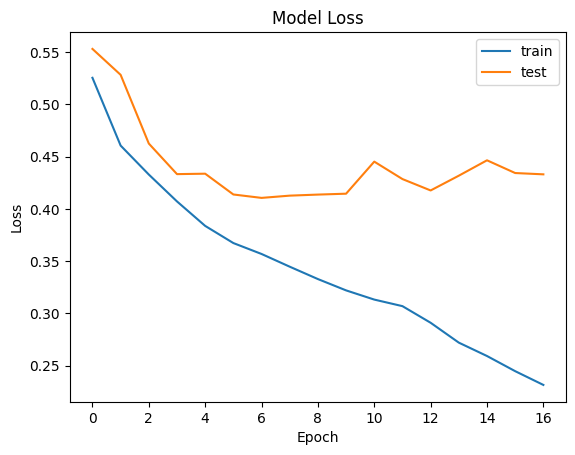

247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
inv_y shape: (7894,)
inv_yhat shape: (7894,)
Test MAPE: 1.814%
Test RMSE: 0.026


In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense,Dropout
from tensorflow.keras.optimizers import Adam

# Create sequences for LSTM
n_steps = 24
X_train, y_train = create_sequences(np.column_stack((y_train_raw, X_train_raw)), n_steps)
X_test, y_test = create_sequences(np.column_stack((y_test_raw, X_test_raw)), n_steps)

# Create the LSTM model
model_bilstm = Sequential()
model_bilstm.add(Bidirectional(LSTM(units=128, activation='tanh',
                   input_shape=(n_steps, X_train.shape[2]),
                   return_sequences=True)))
Dropout(0.2)
model_bilstm.add(Bidirectional(LSTM(units=64, activation='tanh',
                   return_sequences=False)))
model_bilstm.add(Dense(1))

# Compile the model
model_bilstm.compile(optimizer=Adam(learning_rate=0.003),
                  loss="mean_squared_error",
                  metrics=['mean_absolute_error'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',
                             patience=10,
                             restore_best_weights=True)

# Train the model
history_bilstm = model_bilstm.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=64,
    verbose=2,
    shuffle=False,
    callbacks=[early_stopping]
)

# Plot training history
plt.plot(history_bilstm.history['loss'])
plt.plot(history_bilstm.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# Make predictions
yhat = model_bilstm.predict(X_test)

# Ensure the predicted values and test values have the same length
yhat = yhat.flatten()  # Convert to 1D array
y_test = y_test.flatten()

# ** Fix the inverse transform issue **

# Create an empty array for inverse transformation
dummy_data = np.zeros((len(yhat), len(original_columns)))

# Assign predicted values to the correct column index
target_index = list(original_columns).index(target_col)
dummy_data[:, target_index] = yhat

# Inverse transform using the original scaler
inv_yhat = scaler.inverse_transform(dummy_data)[:, target_index]

# Do the same for actual values
dummy_data[:, target_index] = y_test
inv_y = scaler.inverse_transform(dummy_data)[:, target_index]

# Check for shape consistency before computing metrics
print("inv_y shape:", inv_y.shape)
print("inv_yhat shape:", inv_yhat.shape)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
mape = np.mean(np.abs((inv_y - inv_yhat) / inv_y)) * 100

print('Test MAPE: %.3f%%' % mape)
print('Test RMSE: %.3f' % rmse)

#### ***Differecence between train-test line indicates overfitting, so***

Epoch 1/20
417/417 - 7s - 18ms/step - loss: 0.8379 - mean_absolute_error: 0.5929 - val_loss: 0.5703 - val_mean_absolute_error: 0.5536
Epoch 2/20
417/417 - 4s - 9ms/step - loss: 0.5206 - mean_absolute_error: 0.5373 - val_loss: 0.5577 - val_mean_absolute_error: 0.5467
Epoch 3/20
417/417 - 4s - 10ms/step - loss: 0.5006 - mean_absolute_error: 0.5255 - val_loss: 0.5441 - val_mean_absolute_error: 0.5428
Epoch 4/20
417/417 - 4s - 10ms/step - loss: 0.4843 - mean_absolute_error: 0.5127 - val_loss: 0.5412 - val_mean_absolute_error: 0.5350
Epoch 5/20
417/417 - 4s - 9ms/step - loss: 0.4742 - mean_absolute_error: 0.5034 - val_loss: 0.5315 - val_mean_absolute_error: 0.5279
Epoch 6/20
417/417 - 4s - 10ms/step - loss: 0.4657 - mean_absolute_error: 0.4959 - val_loss: 0.5089 - val_mean_absolute_error: 0.5075
Epoch 7/20
417/417 - 4s - 10ms/step - loss: 0.4567 - mean_absolute_error: 0.4871 - val_loss: 0.5022 - val_mean_absolute_error: 0.4915
Epoch 8/20
417/417 - 4s - 10ms/step - loss: 0.4489 - mean_absolu

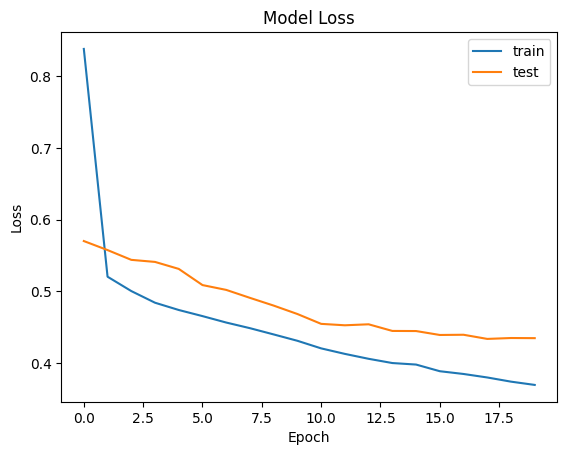

247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
inv_y shape: (7894,)
inv_yhat shape: (7894,)
Test MAPE: 1.918%
Test RMSE: 0.026


In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l2, l1_l2

# Create sequences for LSTM
n_steps = 24
X_train, y_train = create_sequences(np.column_stack((y_train_raw, X_train_raw)), n_steps)
X_test, y_test = create_sequences(np.column_stack((y_test_raw, X_test_raw)), n_steps)

# Create the LSTM model
model_bilstm = Sequential()
model_bilstm.add(Bidirectional(LSTM(units=128, activation='tanh',
                   input_shape=(n_steps, X_train.shape[2]),
                   kernel_regularizer=l2(0.01),      # to improve measures of over-fitting
                   recurrent_regularizer=l2(0.01),   # to improve measures of over-fitting
                   return_sequences=True)))
Dropout(0.2)
model_bilstm.add(Bidirectional(LSTM(units=64, activation='tanh',
                   return_sequences=False)))
model_bilstm.add(Dense(1))

# Compile the model
model_bilstm.compile(optimizer=Adam(learning_rate=0.001),
                  loss="mean_squared_error",
                  metrics=['mean_absolute_error'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',
                             patience=10,
                             restore_best_weights=True)

# Train the model
history_bilstm = model_bilstm.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=64,
    verbose=2,
    shuffle=False,
    callbacks=[early_stopping]
)

# Plot training history
plt.plot(history_bilstm.history['loss'])
plt.plot(history_bilstm.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# Make predictions
yhat = model_bilstm.predict(X_test)

# Ensure the predicted values and test values have the same length
yhat = yhat.flatten()  # Convert to 1D array
y_test = y_test.flatten()

# ** Fix the inverse transform issue **

# Create an empty array for inverse transformation
dummy_data = np.zeros((len(yhat), len(original_columns)))

# Assign predicted values to the correct column index
target_index = list(original_columns).index(target_col)
dummy_data[:, target_index] = yhat

# Inverse transform using the original scaler
inv_yhat = scaler.inverse_transform(dummy_data)[:, target_index]

# Do the same for actual values
dummy_data[:, target_index] = y_test
inv_y = scaler.inverse_transform(dummy_data)[:, target_index]

# Check for shape consistency before computing metrics
print("inv_y shape:", inv_y.shape)
print("inv_yhat shape:", inv_yhat.shape)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
mape = np.mean(np.abs((inv_y - inv_yhat) / inv_y)) * 100

print('Test MAPE: %.3f%%' % mape)
print('Test RMSE: %.3f' % rmse)

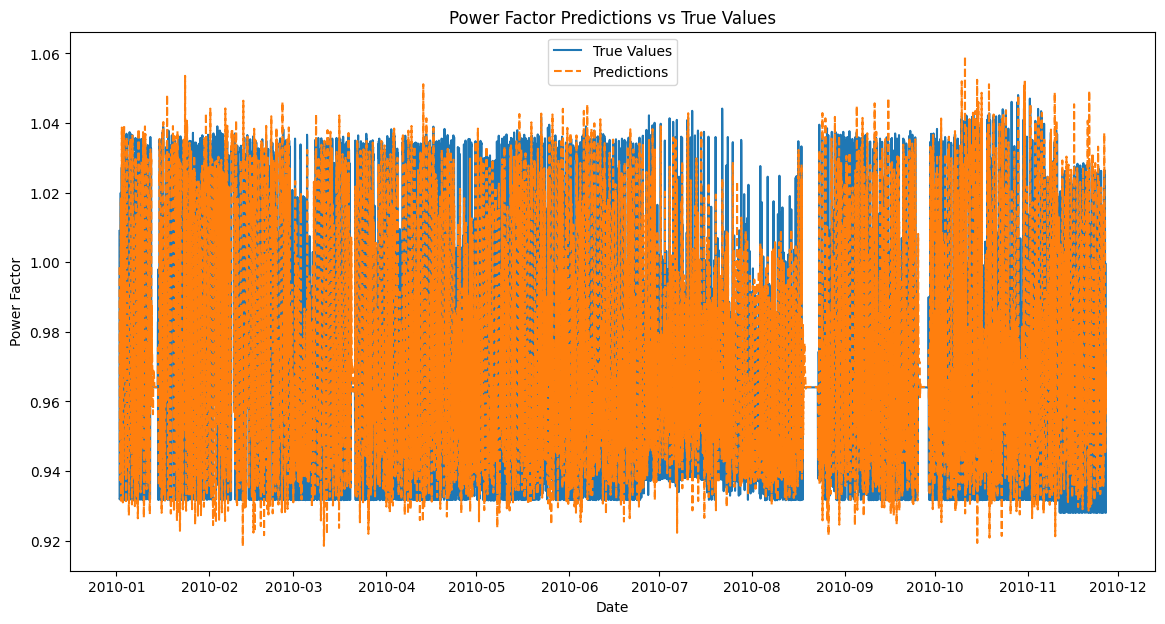

In [37]:
# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(df_hourly.index[-len(inv_y):], inv_y, label='True Values')
plt.plot(df_hourly.index[-len(inv_y):], inv_yhat, label='Predictions', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Power Factor')
plt.title('Power Factor Predictions vs True Values')
plt.legend()
plt.show()

In [38]:
model_bilstm.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_4 (Bidirectional)      │ (None, 24, 256)             │         138,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 908,165 (3.46 MB)

 Trainable params: 302,721 (1.15 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 605,444 (2.31 MB)

### **I think, it is enough for LSTM**

#### ***3.2.2.Gru***

##### ***_GRU (Gated Recurrent Unit) and Its Key Features_***<br><br>

GRU is a recurrent neural network (RNN) model designed to work with sequential data, widely used in tasks such as time series forecasting. Similar to LSTM, it aims to capture long-term dependencies but has a simpler structure. GRU relies on two main components: the cell state and the hidden state. Instead of separate forget, input, and output gates like LSTM, it uses only update and reset gates. This makes it more parameter-efficient, faster to train, and computationally more efficient. Compared to LSTM, it requires less memory, making it advantageous for large datasets and real-time applications. Among time series forecasting methods, it is particularly popular due to its ***high accuracy and low computational cost***.

In [39]:
import numpy as np

def create_sequences(data, n_steps):
    """
    Creates sequences from time series data for LSTM/GRU model input.

    Parameters:
    -----------
    data : numpy array
        Input data with shape (samples, features).
        The last column is assumed to be the target variable.
    n_steps : int
        Number of time steps to look back (sequence length)

    Returns:
    --------
    X : numpy array
        Sequences with shape (samples, timesteps, features)
    y : numpy array
        Target values with shape (samples,)

    Example:
    --------
    # Assuming 'data' is your numpy array with shape (1000, 5)
    # where last column is your target variable
    X, y = create_sequences(data, n_steps=30)
    """
    X, y = [], []
    for i in range(len(data) - n_steps):
        sequence = data[i:(i + n_steps), :]
        target = data[i + n_steps, -1]  # Last column as target
        X.append(sequence)
        y.append(target)

    return np.array(X), np.array(y)

In [40]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

original_columns = df_hourly.columns.tolist()

# Data preprocessing
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_hourly.reset_index(drop=True))
df_scaled = pd.DataFrame(df_scaled, columns=df_hourly.columns, index=df_hourly.index)
df_scaled['Datetime'] = df_hourly.index
df_scaled.set_index('Datetime', inplace=True)

In [41]:
df_scaled.head(3)

voltage  global_intensity  sub_metering_1  \
Datetime                                                          
2006-12-16 17:00:00 -2.077988          3.607876       -0.319086   
2006-12-16 18:00:00 -2.099360          2.938368       -0.319086   
2006-12-16 19:00:00 -2.551344          2.644677       -0.319086   

                     sub_metering_2  sub_metering_3  power_factor  
Datetime                                                           
2006-12-16 17:00:00       -0.184969        1.424259      0.811481  
2006-12-16 18:00:00        1.300378        1.425020      0.872132  
2006-12-16 19:00:00        0.032366        1.399919      0.872329

In [ ]:
# Train-test split
train_df = df_scaled.loc[df_scaled.index < '2010-01-01 00:00:00']
test_df = df_scaled.loc[df_scaled.index >= '2010-01-01 00:00:00']

target_col = 'power_factor'
feature_cols = train_df.columns.drop([target_col])

# Prepare data for LSTM
X_train_raw = train_df[feature_cols].values
y_train_raw = train_df[target_col].values
X_test_raw = test_df[feature_cols].values
y_test_raw = test_df[target_col].values

In [43]:
n_steps = 24
X_train, y_train = create_sequences(np.column_stack((y_train_raw, X_train_raw)), n_steps)
X_test, y_test = create_sequences(np.column_stack((y_test_raw, X_test_raw)), n_steps)

In [44]:
# Calculating metric of WAPE Weighted Absolute Percentage Error
import tensorflow as tf
from tensorflow.keras import backend as K

def wape(y_true, y_pred):
    return K.sum(K.abs(y_true - y_pred)) / K.sum(y_true)

In [45]:
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping


# Build the GRU model
gru_model = Sequential()
gru_model.add(GRU(100, activation='tanh', input_shape=(n_steps, X_train.shape[2])))
gru_model.add(Dense(1))
gru_model.compile(optimizer='adam', loss='mse',metrics=["mean_absolute_error", wape])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10,
                               restore_best_weights=True)

# Train the model with early stopping
history = gru_model.fit(X_train, y_train, epochs=20,
                        validation_data=(X_test, y_test),
                        batch_size=64,
                        callbacks=[early_stopping])

# Evaluate the model
loss = gru_model.evaluate(X_test, y_test)
print("The model creation process was completed successfully")
print("############")
print(f'Validation Loss: {loss}')

Epoch 1/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.6324 - mean_absolute_error: 0.6395 - wape: -341.3997 - val_loss: 0.5191 - val_mean_absolute_error: 0.5356 - val_wape: 13315.1816
Epoch 2/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4802 - mean_absolute_error: 0.5228 - wape: -898.1681 - val_loss: 0.5202 - val_mean_absolute_error: 0.5458 - val_wape: 25047.4473
Epoch 3/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4605 - mean_absolute_error: 0.5080 - wape: 103.0507 - val_loss: 0.4992 - val_mean_absolute_error: 0.5165 - val_wape: 16840.7285
Epoch 4/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4511 - mean_absolute_error: 0.5007 - wape: -151.1889 - val_loss: 0.4735 - val_mean_absolute_error: 0.4999 - val_wape: 19217.4004
Epoch 5/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4414 - mean_absolute_error: 0.4904 - wape: -382.4723 - val_loss: 0.4766 - val_mean_absolute_error: 0.5018 - val_wape: 22467.5820
Epoch 6/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms

In [46]:
# data check
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_train data type:", X_train.dtype)
print("y_train data type:", y_train.dtype)

# NaN and Infinity checking
import numpy as np
print("number of X_train NaN :", np.isnan(X_train).sum())
print("number of y_train NaN :", np.isnan(y_train).sum())
print("number of X_train Infinity :", np.isinf(X_train).sum())
print("number of y_train Infinity :", np.isinf(y_train).sum())

X_train shape: (26647, 24, 6)
y_train shape: (26647,)
X_train data type: float64
y_train data type: float64
number of X_train NaN : 0
number of y_train NaN : 0
number of X_train Infinity : 0
number of y_train Infinity : 0


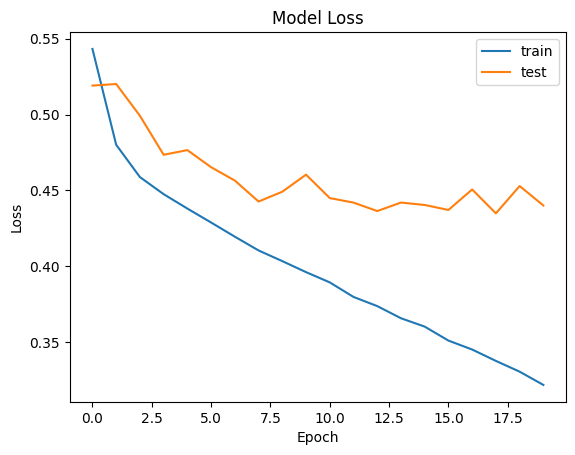

247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
inv_y shape: (7894,)
inv_yhat shape: (7894,)
Test MAPE: 1.903%
Test RMSE: 0.027


In [47]:
# Plot training history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# Make predictions
y_pred = gru_model.predict(X_test)

# Ensure the predicted values and test values have the same length
y_pred = y_pred.flatten()  # Convert to 1D array
y_test = y_test.flatten()

# ** Fix the inverse transform issue **

# Create an empty array for inverse transformation
dummy_data = np.zeros((len(y_pred), len(original_columns)))

# Assign predicted values to the correct column index
target_index = list(original_columns).index(target_col)
dummy_data[:, target_index] = y_pred

# Inverse transform using the original scaler
inv_y_pred = scaler.inverse_transform(dummy_data)[:, target_index]

# Do the same for actual values
dummy_data[:, target_index] = y_test
inv_y = scaler.inverse_transform(dummy_data)[:, target_index]

# Check for shape consistency before computing metrics
print("inv_y shape:", inv_y.shape)
print("inv_yhat shape:", inv_y_pred.shape)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(inv_y, inv_y_pred))
mape = np.mean(np.abs((inv_y - inv_y_pred) / inv_y)) * 100

print('Test MAPE: %.3f%%' % mape)
print('Test RMSE: %.3f' % rmse)

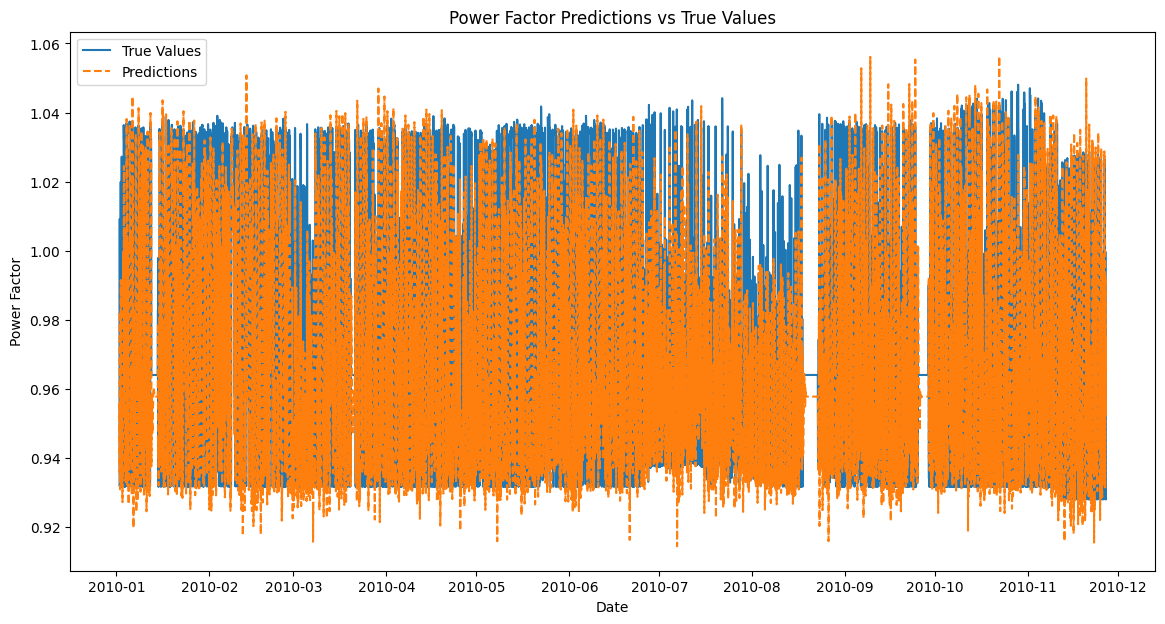

In [48]:
# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(df_hourly.index[-len(inv_y):], inv_y, label='True Values')
plt.plot(df_hourly.index[-len(inv_y):], inv_y_pred, label='Predictions', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Power Factor')
plt.title('Power Factor Predictions vs True Values')
plt.legend()
plt.show()

247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


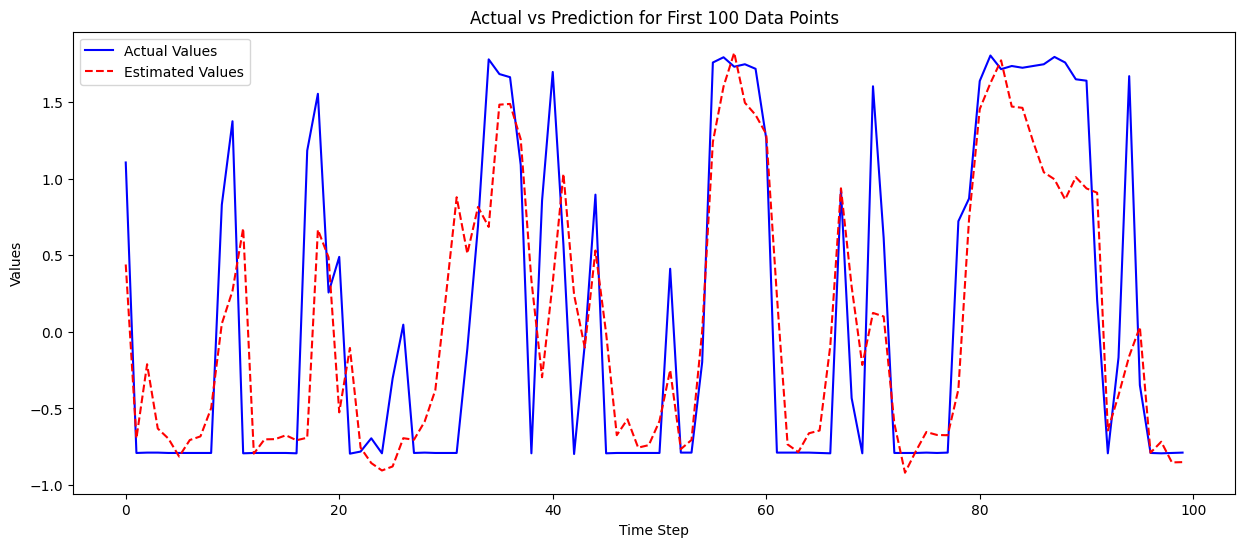

In [49]:
y_pred = gru_model.predict(X_test)
plt.figure(figsize=(15,6))
plt.plot(y_test[:100], label='Actual Values', color='blue')
plt.plot(y_pred[:100], label='Estimated Values', color='red', linestyle='--')
plt.title('Actual vs Prediction for First 100 Data Points')
plt.xlabel('Time Step')
plt.ylabel('Values')
plt.legend()
plt.show()

Epoch 1/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 1.4974 - mean_absolute_error: 0.7240 - wape: 852.6188 - val_loss: 0.6372 - val_mean_absolute_error: 0.6018 - val_wape: 19725.2207
Epoch 2/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.6364 - mean_absolute_error: 0.5852 - wape: -190.8578 - val_loss: 0.5723 - val_mean_absolute_error: 0.5839 - val_wape: 9672.0264
Epoch 3/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.5855 - mean_absolute_error: 0.5741 - wape: 105.9234 - val_loss: 0.5763 - val_mean_absolute_error: 0.5987 - val_wape: 22605.0566
Epoch 4/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.5696 - mean_absolute_error: 0.5615 - wape: 740.8468 - val_loss: 0.5473 - val_mean_absolute_error: 0.5625 - val_wape: 4906.0610
Epoch 5/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.5470 - mean_absolute_error: 0.5524 - wape: 261.9286 - val_loss: 0.6118 - val_mean_absolute_error: 0.5602 - val_wape: 6370.7461
Epoch 6/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step 

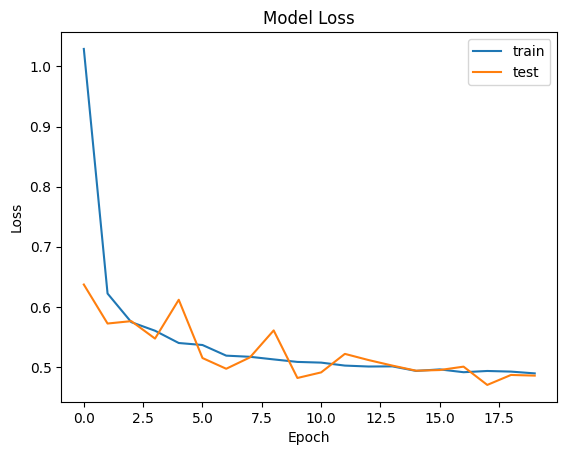

In [50]:
from tensorflow.keras.layers import GRU, Dense,Dropout,BatchNormalization,LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.optimizers import Adam

# Build the GRU model
gru_model = Sequential()
gru_model.add(GRU(128, activation='tanh', input_shape=(n_steps, X_train.shape[2]),
                   kernel_regularizer=l2(0.01),
                   recurrent_regularizer=l2(0.01))
                   ) # to improve measures of over-fitting
gru_model.add(BatchNormalization())
gru_model.add(Dropout(0.2))
gru_model.add(Dense(64, activation=LeakyReLU(alpha=0.1)))
gru_model.add(BatchNormalization())
gru_model.add(Dropout(0.2))
gru_model.add(Dense(32, activation=LeakyReLU(alpha=0.1)))
gru_model.add(Dense(1))

gru_model.compile(optimizer=Adam(learning_rate=0.001,clipnorm=1.0),
                  loss='mse',
                  metrics=["mean_absolute_error", wape])
# clipnorm=1.0 for Gradient clipping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               restore_best_weights=True)

# Adaptive Learning Rate
# reduce_lr = ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=0.5,  # Cut your learning rate in half
#     patience=5,  # If there is no improvement for 5 epochs
#     min_lr=1e-5
# )
# Train the model with early stopping
history = gru_model.fit(X_train, y_train,
                        epochs=20,
                        validation_data=(X_test, y_test),
                        batch_size=64,
                        callbacks=[early_stopping])

# Evaluate the model
loss = gru_model.evaluate(X_test, y_test)
print("The model creation process was completed successfully ")
print("############")
print(f'Validation Loss: {loss}')

# Plot training history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [51]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Make predictions
y_pred = gru_model.predict(X_test)

# Ensure the predicted values and test values have the same length
y_pred = y_pred.flatten()  # Convert to 1D array
y_test = y_test.flatten()

# ** Fix the inverse transform issue **

# Create an empty array for inverse transformation
dummy_data = np.zeros((len(y_pred), len(original_columns)))

# Assign predicted values to the correct column index
target_index = list(original_columns).index(target_col)
dummy_data[:, target_index] = y_pred

# Inverse transform using the original scaler
inv_y_pred = scaler.inverse_transform(dummy_data)[:, target_index]

# Do the same for actual values
dummy_data[:, target_index] = y_test
inv_y = scaler.inverse_transform(dummy_data)[:, target_index]

# Check for shape consistency before computing metrics
print("inv_y shape:", inv_y.shape)
print("inv_yhat shape:", inv_y_pred.shape)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(inv_y, inv_y_pred))
mape = np.mean(np.abs((inv_y - inv_y_pred) / inv_y)) * 100

print('Test MAPE: %.3f%%' % mape)
print('Test RMSE: %.3f' % rmse)

247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
inv_y shape: (7894,)
inv_yhat shape: (7894,)
Test MAPE: 2.009%
Test RMSE: 0.027


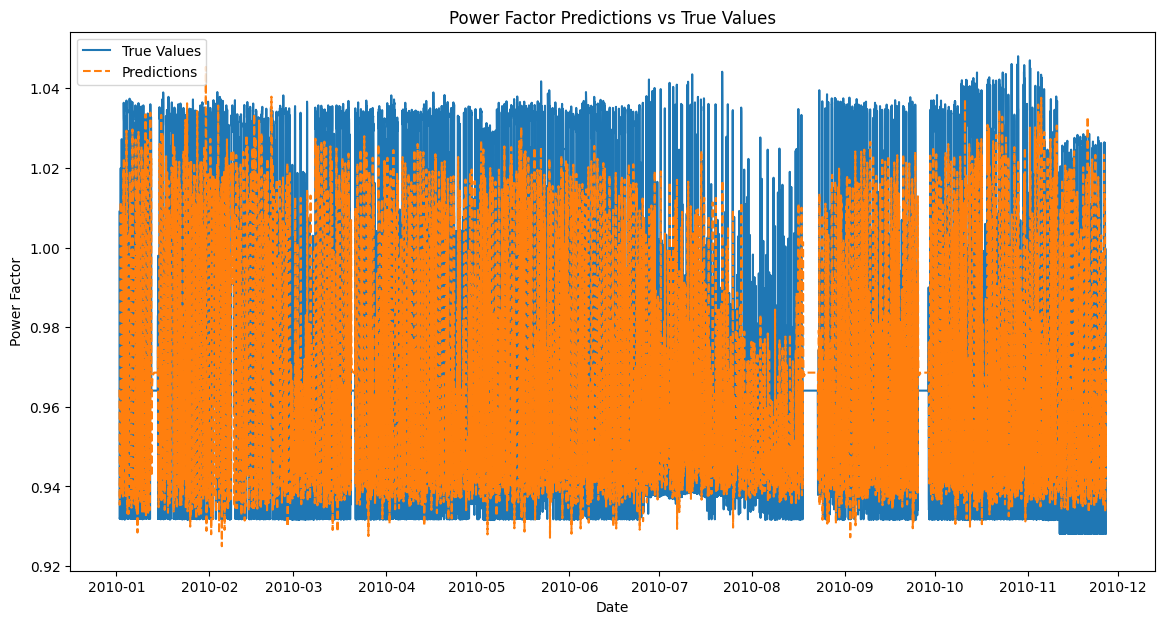

In [52]:
# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(df_hourly.index[-len(inv_y):], inv_y, label='True Values')
plt.plot(df_hourly.index[-len(inv_y):], inv_y_pred, label='Predictions', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Power Factor')
plt.title('Power Factor Predictions vs True Values')
plt.legend()
plt.show()

247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


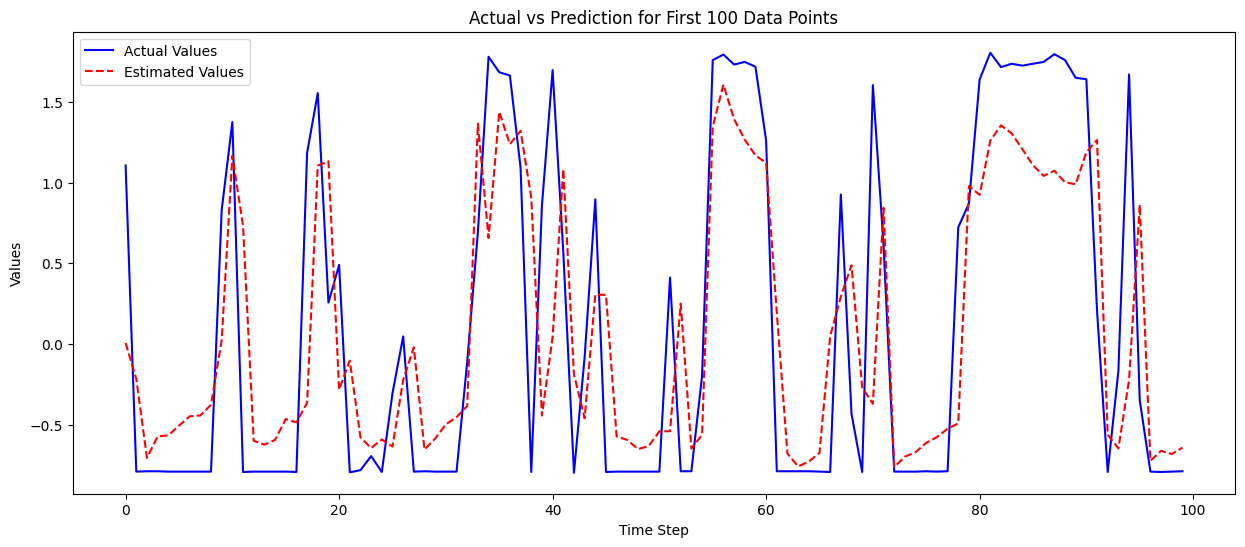

In [53]:
y_pred = gru_model.predict(X_test)
plt.figure(figsize=(15,6))
plt.plot(y_test[:100], label='Actual Values', color='blue')
plt.plot(y_pred[:100], label='Estimated Values', color='red', linestyle='--')
plt.title('Actual vs Prediction for First 100 Data Points')
plt.xlabel('Time Step')
plt.ylabel('Values')
plt.legend()
plt.show()

Epoch 1/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 2.8431 - mean_absolute_error: 0.7865 - wape: -4604.6479 - val_loss: 1.0987 - val_mean_absolute_error: 0.6108 - val_wape: 8815.1973
Epoch 2/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 1.0431 - mean_absolute_error: 0.6119 - wape: 813.7615 - val_loss: 0.7435 - val_mean_absolute_error: 0.5560 - val_wape: 17565.0508
Epoch 3/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.7524 - mean_absolute_error: 0.5805 - wape: 3919.6653 - val_loss: 0.6177 - val_mean_absolute_error: 0.5108 - val_wape: 12771.3750
Epoch 4/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.6525 - mean_absolute_error: 0.5721 - wape: -42225.5078 - val_loss: 0.5647 - val_mean_absolute_error: 0.5185 - val_wape: 22829.1250
Epoch 5/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.6068 - mean_absolute_error: 0.5653 - wape: -569.1041 - val_loss: 0.5530 - val_mean_absolute_error: 0.5196 - val_wape: 17236.6914
Epoch 6/20
417/417 ━━━━━━━━━━━━━━━━━━━━

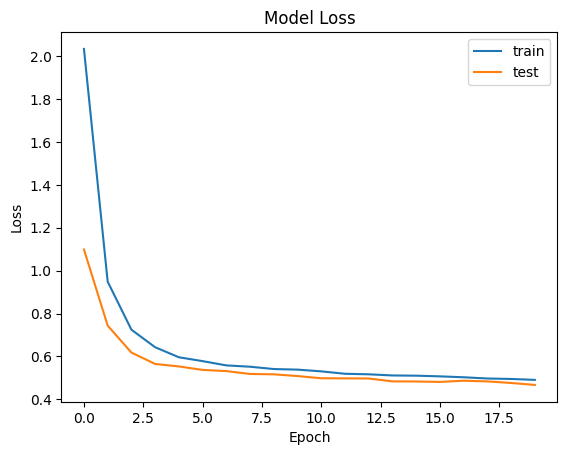

In [74]:
from tensorflow.keras.layers import GRU, Dense,Dropout,BatchNormalization,LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.layers import GRU, Bidirectional
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.optimizers import Adam

# Build the GRU model
bi_gru_model = Sequential()
bi_gru_model.add(Bidirectional(GRU(128, activation='tanh', input_shape=(n_steps, X_train.shape[2]),
                   kernel_regularizer=l2(0.01),
                   recurrent_regularizer=l2(0.01))
                   )) # to improve measures of over-fitting
bi_gru_model.add(BatchNormalization())
bi_gru_model.add(Dropout(0.2))
bi_gru_model.add(Dense(64, activation=LeakyReLU(alpha=0.1)))
bi_gru_model.add(BatchNormalization())
bi_gru_model.add(Dropout(0.2))
bi_gru_model.add(Dense(32, activation=LeakyReLU(alpha=0.1)))
bi_gru_model.add(Dense(1))

bi_gru_model.compile(optimizer=Adam(learning_rate=0.0003,clipnorm=1.0),
                  loss='mse',
                  metrics=["mean_absolute_error", wape])
# clipnorm=1.0 for Gradient clipping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               restore_best_weights=True)

# Adaptive Learning Rate
# reduce_lr = ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=0.5,  # Cut your learning rate in half
#     patience=5,  # If there is no improvement for 5 epochs
#     min_lr=1e-5
# )
# Train the model with early stopping
history = bi_gru_model.fit(X_train, y_train,
                        epochs=20,
                        validation_data=(X_test, y_test),
                        batch_size=64,
                        callbacks=[early_stopping])

# Evaluate the model
loss = bi_gru_model.evaluate(X_test, y_test)
print("The model creation process was completed successfully ")
print("############")
print(f'Validation Loss: {loss}')

# Plot training history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [75]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error,mean_absolute_error

# Make predictions
y_pred = bi_gru_model.predict(X_test)

# Ensure the predicted values and test values have the same length
y_pred = y_pred.flatten()  # Convert to 1D array
y_test = y_test.flatten()

# ** Fix the inverse transform issue **

# Create an empty array for inverse transformation
dummy_data = np.zeros((len(y_pred), len(original_columns)))

# Assign predicted values to the correct column index
target_index = list(original_columns).index(target_col)
dummy_data[:, target_index] = y_pred

# Inverse transform using the original scaler
inv_y_pred = scaler.inverse_transform(dummy_data)[:, target_index]

# Do the same for actual values
dummy_data[:, target_index] = y_test
inv_y = scaler.inverse_transform(dummy_data)[:, target_index]

# Check for shape consistency before computing metrics
print("inv_y shape:", inv_y.shape)
print("inv_yhat shape:", inv_y_pred.shape)

# Calculate metrics
mae = mean_absolute_error(inv_y, inv_y_pred)
rmse = np.sqrt(mean_squared_error(inv_y, inv_y_pred))
mape = np.mean(np.abs((inv_y - inv_y_pred) / inv_y)) * 100

print(f"MAE: {mae:.3f}")
print(f"MAPE:  % {mape:.3f}")
print(f"RMSE: {rmse:.3f}")

247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
inv_y shape: (7894,)
inv_yhat shape: (7894,)
MAE: 0.019
MAPE:  % 1.967
RMSE: 0.027


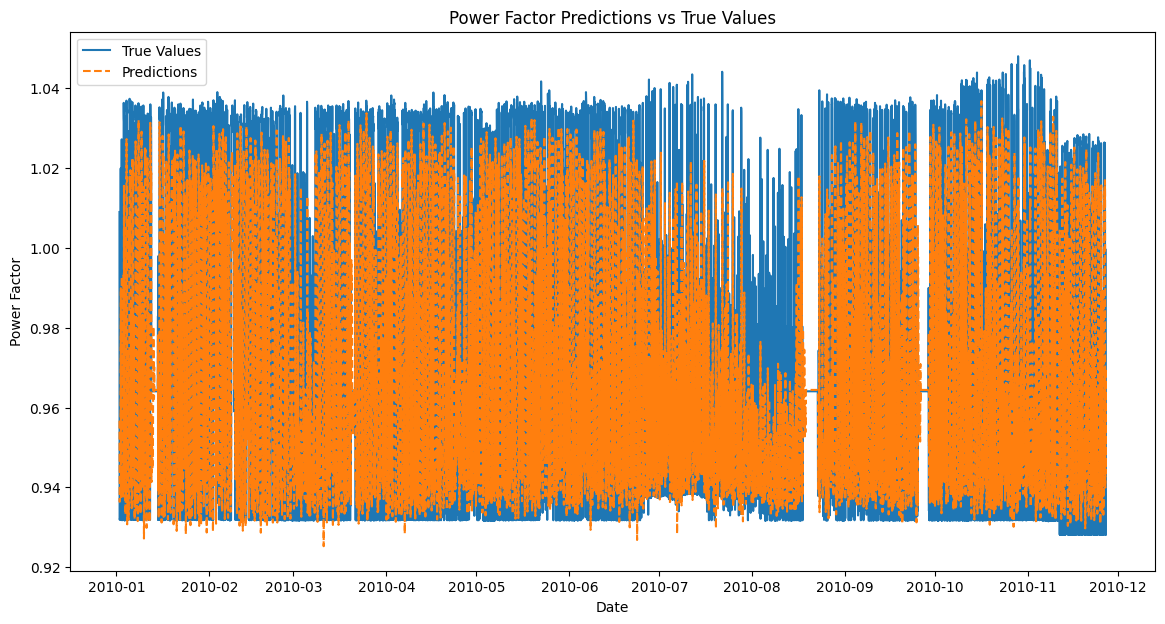

In [76]:
# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(df_hourly.index[-len(inv_y):], inv_y, label='True Values')
plt.plot(df_hourly.index[-len(inv_y):], inv_y_pred, label='Predictions', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Power Factor')
plt.title('Power Factor Predictions vs True Values')
plt.legend()
plt.show()

Epoch 1/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 5.9542 - mean_absolute_error: 0.8121 - wape: -732.4136 - val_loss: 1.2792 - val_mean_absolute_error: 0.6275 - val_wape: 19507.3008
Epoch 2/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 1.1218 - mean_absolute_error: 0.6328 - wape: -478.0802 - val_loss: 0.7322 - val_mean_absolute_error: 0.5496 - val_wape: 24937.6914
Epoch 3/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.7668 - mean_absolute_error: 0.6018 - wape: -173.9029 - val_loss: 0.6416 - val_mean_absolute_error: 0.5373 - val_wape: 39902.6953
Epoch 4/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.6801 - mean_absolute_error: 0.5843 - wape: -14683.8701 - val_loss: 0.6057 - val_mean_absolute_error: 0.5324 - val_wape: 50143.7422
Epoch 5/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.6382 - mean_absolute_error: 0.5761 - wape: 4671.3618 - val_loss: 0.5871 - val_mean_absolute_error: 0.5358 - val_wape: 42132.2383
Epoch 6/20
417/417 ━━━━━━━━━━━━━━━━━━━

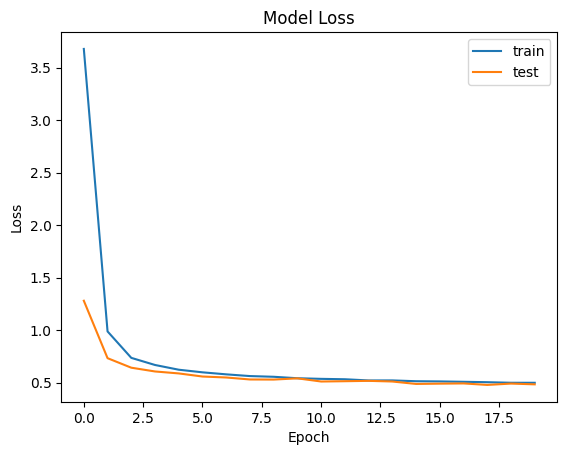

In [91]:
from tensorflow.keras.layers import GRU, Dense,Dropout,BatchNormalization,LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.layers import GRU, Bidirectional
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.optimizers import Adam,SGD

# Build the GRU model
bigru_model = Sequential()
bigru_model.add(Bidirectional(GRU(128, activation='tanh',
                   input_shape=(n_steps, X_train.shape[2]),
                   kernel_regularizer=l2(0.03),
                   recurrent_regularizer=l2(0.03))
                   )) # to improve measures of over-fitting
bigru_model.add(BatchNormalization())
bigru_model.add(Dropout(0.2))
bigru_model.add(Dense(64, activation="relu"))
bigru_model.add(BatchNormalization())
bigru_model.add(Dropout(0.2))
bigru_model.add(Dense(32, activation='relu'))
bigru_model.add(Dense(1))

optimizer = Adam(
    learning_rate=0.0003,
    clipnorm=1.0           # gradient clipping
)

bigru_model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics=["mean_absolute_error", wape])
# clipnorm=1.0 for Gradient clipping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               restore_best_weights=True)


# Train the model with early stopping
history = bigru_model.fit(X_train, y_train,
                        epochs=20,
                        validation_data=(X_test, y_test),
                        batch_size=64,
                        callbacks=[early_stopping])

# Evaluate the model
loss = bigru_model.evaluate(X_test, y_test)
print("The model creation process was completed successfully ")
print("############")
print(f'Validation Loss: {loss}')

# Plot training history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [92]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error,mean_absolute_error

# Make predictions
y_pred = bigru_model.predict(X_test)

# Ensure the predicted values and test values have the same length
y_pred = y_pred.flatten()  # Convert to 1D array
y_test = y_test.flatten()

# ** Fix the inverse transform issue **

# Create an empty array for inverse transformation
dummy_data = np.zeros((len(y_pred), len(original_columns)))

# Assign predicted values to the correct column index
target_index = list(original_columns).index(target_col)
dummy_data[:, target_index] = y_pred

# Inverse transform using the original scaler
inv_y_pred = scaler.inverse_transform(dummy_data)[:, target_index]

# Do the same for actual values
dummy_data[:, target_index] = y_test
inv_y = scaler.inverse_transform(dummy_data)[:, target_index]

# Check for shape consistency before computing metrics
print("inv_y shape:", inv_y.shape)
print("inv_yhat shape:", inv_y_pred.shape)

# Calculate metrics
mae = mean_absolute_error(inv_y, inv_y_pred)
rmse = np.sqrt(mean_squared_error(inv_y, inv_y_pred))
mape = np.mean(np.abs((inv_y - inv_y_pred) / inv_y)) * 100

print(f"MAE: {mae:.3f}")
print(f"MAPE:  % {mape:.3f}")
print(f"RMSE: {rmse:.3f}")

247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
inv_y shape: (7894,)
inv_yhat shape: (7894,)
MAE: 0.021
MAPE:  % 2.112
RMSE: 0.028


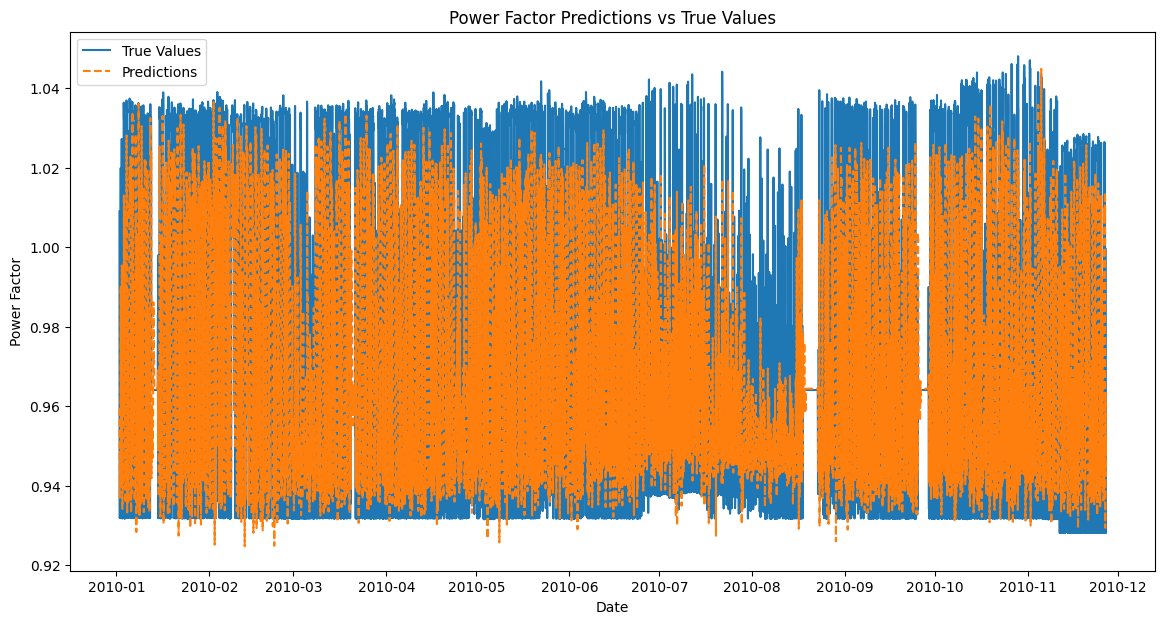

In [93]:
# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(df_hourly.index[-len(inv_y):], inv_y, label='True Values')
plt.plot(df_hourly.index[-len(inv_y):], inv_y_pred, label='Predictions', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Power Factor')
plt.title('Power Factor Predictions vs True Values')
plt.legend()
plt.show()

In [94]:
bigru_model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_10 (Bidirectional)     │ (None, 256)                 │         104,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 371,589 (1.42 MB)

 Trainable params: 123,649 (483.00 KB)

 Non-trainable params: 640 (2.50 KB)

 Optimizer params: 247,300 (966.02 KB)

In [95]:
error_per = (np.abs(inv_y - inv_y_pred) / inv_y)*100
df_results = pd.DataFrame(data={"actual": inv_y[:20], "pred": inv_y_pred[:20],"error%": error_per[:20]})
df_results

actual      pred    error%
0   1.009007  0.959505  4.906001
1   0.931919  0.943827  1.277720
2   0.932012  0.936962  0.531084
3   0.932012  0.938143  0.657802
4   0.931919  0.940619  0.933554
5   0.931919  0.946122  1.523986
6   0.931919  0.948517  1.781028
7   0.931919  0.946563  1.571332
8   0.931919  0.949680  1.905816
9   0.997783  0.963305  3.455464
10  1.019953  0.990284  2.908880
11  0.931827  0.986621  5.880363
12  0.931919  0.940254  0.894343
13  0.931919  0.941762  1.056126
14  0.931919  0.944552  1.355577
15  0.931919  0.946916  1.609178
16  0.931827  0.947633  1.696326
17  1.012161  0.948355  6.303978
18  1.027232  0.988449  3.775412
19  0.974499  0.995402  2.145006

#### ***3.2.3.DeepAR(Amazon timeseries algorithm):***

For advanced time-series forecasting, Amazon Corporation developed a state-of-the-art probabilistic forecasting algorithm which is known as the Deep Autoregressive or DeepAR forecasting algorithm. This is one kind of Deep Learning model that is specifically designed to capture the inherent uncertainties associated with future predictions. Unlike traditional forecasting methods that rely on deterministic point estimates, DeepAR provides a probability distribution over future values, allowing decision-makers to assess the range of possible outcomes and make more informed decisions.
DeepAR is powerful algorithm, which has gained prominence for its effectiveness in handling complex temporal patterns and generating accurate forecasts. DeepAR is particularly well-suited for scenarios where multiple related time series need to be forecasted simultaneously, making it a valuable tool in various domains like finance, e-commerce, and supply chain management.

DeepAR is a time series forecasting model with the following key working principles:

***Autoregressive Architecture:***  DeepAR employs an autoregressive neural network architecture, where the predictions for each time step depend on a combination of historical observations and ***the model's own past predictions***. This enables the algorithm to capture more complex dependencies within the time series data, making it adept at handling sequences with intricate patterns and trends.<br>
***Embedding of Categorical Features:*** DeepAR can seamlessly incorporate information from categorical features associated with time series data. This is achieved through the use of embeddings, which transform categorical variables into continuous vectors. The inclusion of such features enhances the model's ability to discern patterns and relationships within the data, especially in scenarios where external factors influence the time series.<br>
***Temporal Attention Mechanism:*** To effectively weigh the importance of different time points in the historical data, DeepAR utilizes a temporal attention mechanism. This mechanism enables the model to focus on relevant portions of the time series, adapting its attention dynamically based on the patterns present in the data.<br>
***Training with Quantile Loss:*** DeepAR is trained using a probabilistic approach that minimizes the quantile loss. This means the model is optimized to generate prediction intervals, representing the range of possible future values with associated confidence levels. This probabilistic framework is particularly valuable in decision-making processes, providing decision-makers with a nuanced understanding of the uncertainty associated with the forecasts.

In [7]:
!pip install gluonts
!pip install "gluonts[torch]" # gluon time series library with pytorch backend

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 18.8 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 14.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 50.2 MB/s eta 0:00:00
  Attempting uninstall: pytorch-lightning
    Found existing installation: pytorch-lightning 2.5.0.post0
    Uninstalling pytorch-lightning-2.5.0.post0:
      Successfully uninstalled pytorch-lightning-2.5.0.post0


In [8]:
from gluonts.torch.model.deepar import DeepAREstimator
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName
from gluonts.evaluation.backtest import make_evaluation_predictions
from tqdm.autonotebook import tqdm
from gluonts.evaluation import Evaluator

### ***3.3.1.Model defining***<br>

The DeepAR estimator model by defining its various hyper-parameters which are listed below--><br>

**freq:** this parameter defines the frequency of the time series data. It represents the number of time steps in one period or cycle of the time series. Our data has minute observations but due to computational time we will resample to hourly, so, the frequency is determined by the variable freq.<br>
**context_length:** This parameter sets the number of time steps that the model uses to learn patterns and dependencies in the historical data. Here it is set to (24 * 5), indicating that the model looks back over a period equivalent to 5 days (by assuming each time step corresponds to an hour).<br>
**prediction_length:** This parameter specifies how far into the future the model should generate predictions. It determines the length of the forecast horizon.<br>
**cardinality:** This parameter is a list that indicates the number of categories for each categorical feature in the dataset.
**num_layers:** It determines the number of layers in the neural network architecture. In our case, the model is configured with 2 layers.<br>
**dropout_rate:** It is a regularization technique that helps prevent overfitting. It represents the fraction of input units to drop out during training. A value of 0.25 means that 25% of the input units will be randomly set to zero during each update.<br>
**trainer_kwargs:** This is a dictionary containing additional arguments for the training process. In our case, it includes: 'max_epochs':16, which sets the maximum number of training epochs. An epoch is one complete pass through the entire training dataset.

In [98]:
!pip install --upgrade pip
!pip install --upgrade setuptools

In [9]:
df_hourly = df.resample('1H').mean()

In [10]:
df_hourly.index.min(),df_hourly.index.max()

(Timestamp('2006-12-16 17:00:00'), Timestamp('2010-11-26 21:00:00'))

In [11]:
df_hourly.columns

Index(['voltage', 'global_intensity', 'sub_metering_1', 'sub_metering_2',
       'sub_metering_3', 'power_factor'],
      dtype='object')

In [12]:
from gluonts.dataset.field_names import FieldName
from gluonts.dataset.common import ListDataset
from gluonts.dataset.pandas import PandasDataset

freq = "1H"  # rate at which dataset is sampled
start_train = pd.Timestamp("2006-12-16 17:00:00")
start_test = pd.Timestamp("2010-01-01 00:00:00")
prediction_lentgh = 24 * 1  # Our prediction Length is 1 Day

# training and testing sets split
df_train = df_hourly.loc[df_hourly.index < '2010-01-01 00:00:00']
df_test = df_hourly.loc[df_hourly.index >= '2010-01-01 00:00:00']

# Prepare the training and testing datasets for DeepAR

# Set the target column to 'power_factor' and use other columns as features
target_col = 'power_factor'
feature_cols = ['voltage', 'global_intensity', 'sub_metering_1', 'sub_metering_2', 'sub_metering_3']


# Training dataset
# I used PandasDataset instead of Listdataset above for correct data format,
train_ds = PandasDataset(
    df_train,
    target=target_col,
    feat_dynamic_real=feature_cols,
    freq=freq
)

# Testing dataset
#  I used PandasDataset instead of Listdataset above for correct data format
test_ds = PandasDataset(
    df_test,
    target=target_col,
    feat_dynamic_real=feature_cols,
    freq=freq
)

In [13]:
for i, data_entry in enumerate(train_ds):
    print(f"Veri girişi {i}:")
    print(data_entry)
    if i >= 5:  # It is enough to see the first few examples
        break

Veri girişi 0:
{'start': Period('2006-12-16 17:00', 'h'), 'target': array([0.99705199, 0.99951761, 0.99952564, ..., 0.99682769, 0.99641199,
       0.99695724]), 'feat_dynamic_real': array([[234.64388889, 234.58016667, 233.2325    , ..., 236.6415    ,
        237.91383333, 240.07133333],
       [ 18.1       ,  15.6       ,  14.50333333, ...,  12.1       ,
          8.52      ,   6.95666667],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.52777778,   6.71666667,   1.43333333, ...,   0.35      ,
          0.53333333,   0.        ],
       [ 16.86111111,  16.86666667,  16.68333333, ...,  18.71666667,
         17.98333333,  18.31666667]])}


In [15]:
for i, d_test_entry in enumerate(test_ds):
    print(f"Veri girişi {i}:")
    print(d_test_entry)
    if i >= 5:  # It is enough to see the first few examples
        break

Veri girişi 0:
{'start': Period('2010-01-01 00:00', 'h'), 'target': array([0.98961909, 0.97173193, 0.98150398, ..., 0.99870591, 0.99717618,
       1.        ]), 'feat_dynamic_real': array([[2.41300000e+02, 2.41620667e+02, 2.44012333e+02, ...,
        2.36741000e+02, 2.39396000e+02, 2.39690000e+02],
       [4.47666667e+00, 2.72333333e+00, 2.65333333e+00, ...,
        7.05666667e+00, 4.91333333e+00, 3.80000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 8.00000000e-01, 0.00000000e+00, ...,
        6.66666667e-02, 1.06666667e+00, 0.00000000e+00],
       [8.51666667e+00, 6.50000000e-01, 6.66666667e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])}


In [18]:
for i, entry in enumerate(test_ds):
    print(f"Seri {i}: Uzunluk = {len(entry['target'])}")

Seri 0: Uzunluk = 7918


In [34]:
for i, entry in enumerate(train_ds):
    print(f"Seri {i}: Uzunluk = {len(entry['target'])}")

Seri 0: Uzunluk = 26671


In [33]:
# context length is number of time steps will look back(Inspired by the value 
# in the LSTM model I created above and liked the results, I set it as 24 here.)

from gluonts.torch.model.deepar import DeepAREstimator

estimator = DeepAREstimator(
    freq=freq,  # hourly frequens
    prediction_length=prediction_lentgh,  # The number of periods we want to predict
    context_length=24*1,  # Number of periods to be used as history
    num_layers=2,  # LSTM layers
    hidden_size=40, # Number of RNN cells for each layer (default: 40)
    dropout_rate=0.1,
    patience = 10,  # Patience parameter for learning rate scheduler (default=10)
    lr = 0.001,   # learning rate
    num_feat_dynamic_real=5,  # number of features except target
    batch_size=64,
    trainer_kwargs={'max_epochs':16,"accelerator": "gpu", "devices": 1}  # use only one GPU 

)

In [35]:
predictor = estimator.train(training_data=train_ds)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: 
  | Name  | Type        | Params | Mode  | In sizes                                                        | Out sizes   
-------------------------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 28.4 K | train | [[1, 1], [1, 1], [1, 744, 10], [1, 744], [1, 744], [1, 24, 10]] | [1, 100, 24]
-------------------------------------------------------------------------------------------------------------------------------
28.4 K    Trainable params
0         Non-trainable params
28.4 K    Total params
0.114     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 50: 'train_loss' reached 0.42993 (best 0.42993), saving model to '/kaggle/working/lightning_logs/version_0/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO: Epoch 1, global step 100: 'train_loss' reached -1.70284 (best -1.70284), saving model to '/kaggle/working/lightning_logs/version_0/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO: Epoch 2, global step 150: 'train_loss' reached -2.03532 (best -2.03532), saving model to '/kaggle/working/lightning_logs/version_0/checkpoints/epoch=2-step=150.ckpt' as top 1
INFO: Epoch 3, global step 200: 'train_loss' reached -2.13109 (best -2.13109), saving model to '/kaggle/working/lightning_logs/version_0/checkpoints/epoch=3-step=200.ckpt' as top 1
INFO: Epoch 4, global step 250: 'train_loss' reached -2.15620 (best -2.15620), saving model to '/kaggle/working/lightning_logs/version_0/checkpoints/epoch=4-step=250.ckpt' as top 1
INFO: Epoch 5, global step 300: 'train_loss' reached -2.20580 (best -2.20580), saving model to '/ka

In [36]:
print(type(predictor))

<class 'gluonts.torch.model.predictor.PyTorchPredictor'>


In [37]:
import pickle

# Eğitilmiş modeli kaydetme
with open("deepar_predictor.pkl", "wb") as f:
    pickle.dump(predictor, f)

print("Predictor saved successfully!")

Predictor saved successfully!


In [38]:
# DeepAR itself provides a wide range of performance metrics like quantile loss, MAPE etc.
# Convert test data and predictions to iterator
import sys
sys.modules['mxnet'] = None

forecast_iterator, test_iterator = make_evaluation_predictions(
    dataset=test_ds,
    predictor=predictor,
    num_samples=100  # Monte Carlo sampling number
)

evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9],num_workers=1)
agg_metrics, item_metrics = evaluator(test_iterator, forecast_iterator,num_series=None)
item_metrics

Running evaluation: 1it [00:00, 16.49it/s]


item_id    forecast_start      MSE  abs_error  abs_target_sum  \
0    None  2010-11-25 22:00  0.00013   0.239322       23.635785   

   abs_target_mean  seasonal_error     MASE     MAPE     sMAPE  \
0         0.984824        0.022279  0.44758  0.01018  0.010123   

   num_masked_target_values        ND      MSIS  QuantileLoss[0.1]  \
0                       0.0  0.010125  4.598691           0.079301   

   Coverage[0.1]  QuantileLoss[0.5]  Coverage[0.5]  QuantileLoss[0.9]  \
0       0.041667           0.239322       0.791667           0.149378   

   Coverage[0.9]  
0            1.0

In [39]:
item_metrics.T

0
item_id                               None
forecast_start            2010-11-25 22:00
MSE                                0.00013
abs_error                         0.239322
abs_target_sum                   23.635785
abs_target_mean                   0.984824
seasonal_error                    0.022279
MASE                               0.44758
MAPE                               0.01018
sMAPE                             0.010123
num_masked_target_values               0.0
ND                                0.010125
MSIS                              4.598691
QuantileLoss[0.1]                 0.079301
Coverage[0.1]                     0.041667
QuantileLoss[0.5]                 0.239322
Coverage[0.5]                     0.791667
QuantileLoss[0.9]                 0.149378
Coverage[0.9]                          1.0

In [40]:
agg_metrics

{'MSE': 0.00013005572046201,
 'abs_error': 0.2393215998426219,
 'abs_target_sum': 23.635784652295484,
 'abs_target_mean': 0.9848243605123118,
 'seasonal_error': 0.022279241655652798,
 'MASE': 0.4475795667060255,
 'MAPE': 0.010180223698595595,
 'sMAPE': 0.010122825884007125,
 'MSIS': 4.5986914318748795,
 'num_masked_target_values': 0.0,
 'QuantileLoss[0.1]': 0.07930124674129675,
 'Coverage[0.1]': 0.041666666666666664,
 'QuantileLoss[0.5]': 0.2393215998426219,
 'Coverage[0.5]': 0.7916666666666666,
 'QuantileLoss[0.9]': 0.14937775801365072,
 'Coverage[0.9]': 1.0,
 'RMSE': 0.011404197493116735,
 'NRMSE': 0.011579930341268365,
 'ND': 0.010125392635077137,
 'wQuantileLoss[0.1]': 0.0033551349323871545,
 'wQuantileLoss[0.5]': 0.010125392635077137,
 'wQuantileLoss[0.9]': 0.006319983034671256,
 'mean_absolute_QuantileLoss': 0.15600020153252311,
 'mean_wQuantileLoss': 0.006600170200711849,
 'MAE_Coverage': 0.5,
 'OWA': nan}

In [41]:
# View results
print("\nAggregate Metrics:")
for metric, value in agg_metrics.items():
    print(f"{metric}: {value}")

print("\nItem Metrics:")
for metric, value in item_metrics.items():
    print(f"{metric}: {value}")


Aggregate Metrics:
MSE: 0.00013005572046201
abs_error: 0.2393215998426219
abs_target_sum: 23.635784652295484
abs_target_mean: 0.9848243605123118
seasonal_error: 0.022279241655652798
MASE: 0.4475795667060255
MAPE: 0.010180223698595595
sMAPE: 0.010122825884007125
MSIS: 4.5986914318748795
num_masked_target_values: 0.0
QuantileLoss[0.1]: 0.07930124674129675
Coverage[0.1]: 0.041666666666666664
QuantileLoss[0.5]: 0.2393215998426219
Coverage[0.5]: 0.7916666666666666
QuantileLoss[0.9]: 0.14937775801365072
Coverage[0.9]: 1.0
RMSE: 0.011404197493116735
NRMSE: 0.011579930341268365
ND: 0.010125392635077137
wQuantileLoss[0.1]: 0.0033551349323871545
wQuantileLoss[0.5]: 0.010125392635077137
wQuantileLoss[0.9]: 0.006319983034671256
mean_absolute_QuantileLoss: 0.15600020153252311
mean_wQuantileLoss: 0.006600170200711849
MAE_Coverage: 0.5
OWA: nan

Item Metrics:
item_id: 0    None
Name: item_id, dtype: object
forecast_start: 0    2010-11-25 22:00
Name: forecast_start, dtype: period[h]
MSE: 0    0.00013

In [27]:
import pickle


with open("deepar_item_metrics.pkl", "wb") as f:
    pickle.dump(item_metrics, f)

In [28]:
import pickle


with open("deepar_agg_metrics.pkl", "wb") as f:
    pickle.dump(agg_metrics, f)

In [44]:
import pickle

# Forecast iterator'ı kaydet
with open("forecast_iterator.pkl", "wb") as f:
    pickle.dump(list(forecast_iterator), f)

# Test iterator'ı kaydet
with open("test_iterator.pkl", "wb") as f:
    pickle.dump(list(test_iterator), f)

print("forecast_iterator ve test_iterator saved successfully!")

forecast_iterator ve test_iterator saved successfully!


In [65]:
import pandas as pd
import numpy as np
from typing import List

# First create the forecasts and test data iterators
forecast_iterator, test_iterator = make_evaluation_predictions(
    dataset=test_ds,
    predictor=predictor,
    num_samples=100  # Monte Carlo sampling number
)

# Convert iterators to lists to avoid consuming them
forecasts = list(forecast_iterator)
test_data = list(test_iterator)

# Initialize empty lists to store the data
timestamps = []
actual_values = []
predicted_values = []
lower_bounds = []
upper_bounds = []

# Helper function to safely get attributes, handling methods vs properties
def safe_get_attr(obj, attr_name):
    """Safely get attribute value, handling case where it might be a method"""
    try:
        attr = getattr(obj, attr_name, None)
        if attr is None:
            return None
        if callable(attr):
            return attr()  # Call the method if it's callable
        return attr  # Return the value if it's not callable
    except Exception as e:
        print(f"Error accessing {attr_name}: {e}")
        return None

# Process each forecast and test entry pair
for i, (test_entry, forecast) in enumerate(zip(test_data, forecasts)):
    # Get forecast mean safely
    forecast_mean = safe_get_attr(forecast, 'mean')
    if forecast_mean is None or len(forecast_mean) == 0:
        print(f"Warning: Forecast {i} has no mean values, skipping")
        continue
    
    # Get the start date and target based on test_entry type
    start_date = None
    target = None
    
    if isinstance(test_entry, dict):
        # Dictionary format
        start_val = test_entry.get("start")
        if start_val is not None:
            if hasattr(start_val, "to_timestamp") and callable(getattr(start_val, "to_timestamp")):
                start_date = start_val.to_timestamp(how='start')
            else:
                start_date = pd.Timestamp(start_val)
        target = test_entry.get("target", [])
        
    elif isinstance(test_entry, pd.DataFrame):
        # DataFrame format
        if 'start' in test_entry.columns:
            start_val = test_entry['start'].iloc[0]
            if hasattr(start_val, "to_timestamp") and callable(getattr(start_val, "to_timestamp")):
                start_date = start_val.to_timestamp(how='start')
            else:
                start_date = pd.Timestamp(start_val)
        elif isinstance(test_entry.index, pd.DatetimeIndex):
            start_date = test_entry.index[0]
        elif isinstance(test_entry.index, pd.PeriodIndex):
            start_date = test_entry.index[0].to_timestamp(how='start')
        
        # Get target data
        if 'target' in test_entry.columns:
            target = test_entry['target'].values
        else:
            numeric_cols = test_entry.select_dtypes(include=[np.number]).columns
            if len(numeric_cols) > 0:
                target = test_entry[numeric_cols[0]].values
            else:
                target = []
    
    else:
        # GluonTS Entry object or other object
        start_val = safe_get_attr(test_entry, 'start')
        if start_val is not None:
            if hasattr(start_val, "to_timestamp") and callable(getattr(start_val, "to_timestamp")):
                start_date = start_val.to_timestamp(how='start')
            else:
                start_date = pd.Timestamp(start_val)
        
        target_val = safe_get_attr(test_entry, 'target')
        if target_val is not None:
            target = np.array(target_val)
        else:
            target = []
    
    # If start_date is still None, try to get it from the forecast
    if start_date is None:
        start_val = safe_get_attr(forecast, 'start_date')
        if start_val is not None:
            if hasattr(start_val, "to_timestamp") and callable(getattr(start_val, "to_timestamp")):
                start_date = start_val.to_timestamp(how='start')
            else:
                start_date = pd.Timestamp(start_val)
        else:
            # Last resort - use current time
            start_date = pd.Timestamp.now()
    
    # Ensure start_date has the right frequency
    try:
        if not hasattr(start_date, 'freq') or start_date.freq is None:
            start_date = start_date.to_period('H').to_timestamp(how='start')
    except Exception as e:
        print(f"Error setting frequency: {e}")
        start_date = pd.Timestamp.now().to_period('H').to_timestamp(how='start')
    
    # Create time range
    time_range = pd.date_range(start=start_date, periods=len(forecast_mean), freq="H")
    
    # Get actual values for forecast period
    if target is not None and len(target) > 0:
        if len(target) >= len(forecast_mean):
            actual_data = target[-len(forecast_mean):]
        else:
            actual_data = list(target) + [np.nan] * (len(forecast_mean) - len(target))
    else:
        actual_data = [np.nan] * len(forecast_mean)
    
    # Add data to lists
    timestamps.extend(time_range)
    actual_values.extend(actual_data)
    predicted_values.extend(forecast_mean)
    
    # Get quantiles safely
    quantiles = None
    if hasattr(forecast, 'quantiles'):
        quantiles = safe_get_attr(forecast, 'quantiles')
    elif hasattr(forecast, 'quantile'):
        quantiles = safe_get_attr(forecast, 'quantile')
    
    if quantiles is not None:
        # Handle different key formats
        if "0.1" in quantiles:
            lower_bounds.extend(quantiles["0.1"])
        elif 0.1 in quantiles:
            lower_bounds.extend(quantiles[0.1])
        else:
            lower_bounds.extend([None] * len(forecast_mean))
            
        if "0.9" in quantiles:
            upper_bounds.extend(quantiles["0.9"])
        elif 0.9 in quantiles:
            upper_bounds.extend(quantiles[0.9])
        else:
            upper_bounds.extend([None] * len(forecast_mean))
    else:
        # Try to compute from samples
        samples = safe_get_attr(forecast, 'samples')
        if samples is not None and len(samples) > 0:
            lower_bounds.extend(np.quantile(samples, 0.1, axis=0))
            upper_bounds.extend(np.quantile(samples, 0.9, axis=0))
        else:
            lower_bounds.extend([None] * len(forecast_mean))
            upper_bounds.extend([None] * len(forecast_mean))

# Create the DataFrame
if timestamps:
    predictions_df = pd.DataFrame({
        "timestamp": timestamps,
        "actual": actual_values,
        "forecast": predicted_values,
        "lower_bound": lower_bounds,
        "upper_bound": upper_bounds
    })
    
    # Display the first few rows of the predictions
    print(predictions_df.head(10))
else:
    print("No data was collected. Check if test_ds and predictor contain valid data.")

Error accessing quantile: SampleForecast.quantile() missing 1 required positional argument: 'q'
            timestamp    actual  forecast  lower_bound  upper_bound
0 2010-01-01 00:00:00  0.996001  0.999707     0.971882     1.024743
1 2010-01-01 01:00:00  0.978795  0.996339     0.968570     1.026375
2 2010-01-01 02:00:00  0.957529  0.971704     0.948887     0.993055
3 2010-01-01 03:00:00  0.955884  0.971255     0.945942     1.008537
4 2010-01-01 04:00:00  0.961313  0.969198     0.939152     0.995037
5 2010-01-01 05:00:00  0.959853  0.971536     0.949530     0.991555
6 2010-01-01 06:00:00  0.946559  0.972040     0.946766     1.007048
7 2010-01-01 07:00:00  0.976189  0.968612     0.945473     0.995982
8 2010-01-01 08:00:00  0.981559  0.986708     0.959226     1.011542
9 2010-01-01 09:00:00  0.998726  1.011605     0.989290     1.027024


In [66]:
# CSV olarak kaydet
predictions_df.to_csv("deepar_predictions.csv", index=False)
print("Tahmin sonuçları 'deepar_predictions.csv' olarak kaydedildi.")


Tahmin sonuçları 'deepar_predictions.csv' olarak kaydedildi.


In [67]:
deepar_pred = pd.DataFrame(predictions_df)
deepar_pred.head(10)

timestamp    actual  forecast  lower_bound  upper_bound
0 2010-01-01 00:00:00  0.996001  0.999707     0.971882     1.024743
1 2010-01-01 01:00:00  0.978795  0.996339     0.968570     1.026375
2 2010-01-01 02:00:00  0.957529  0.971704     0.948887     0.993055
3 2010-01-01 03:00:00  0.955884  0.971255     0.945942     1.008537
4 2010-01-01 04:00:00  0.961313  0.969198     0.939152     0.995037
5 2010-01-01 05:00:00  0.959853  0.971536     0.949530     0.991555
6 2010-01-01 06:00:00  0.946559  0.972040     0.946766     1.007048
7 2010-01-01 07:00:00  0.976189  0.968612     0.945473     0.995982
8 2010-01-01 08:00:00  0.981559  0.986708     0.959226     1.011542
9 2010-01-01 09:00:00  0.998726  1.011605     0.989290     1.027024

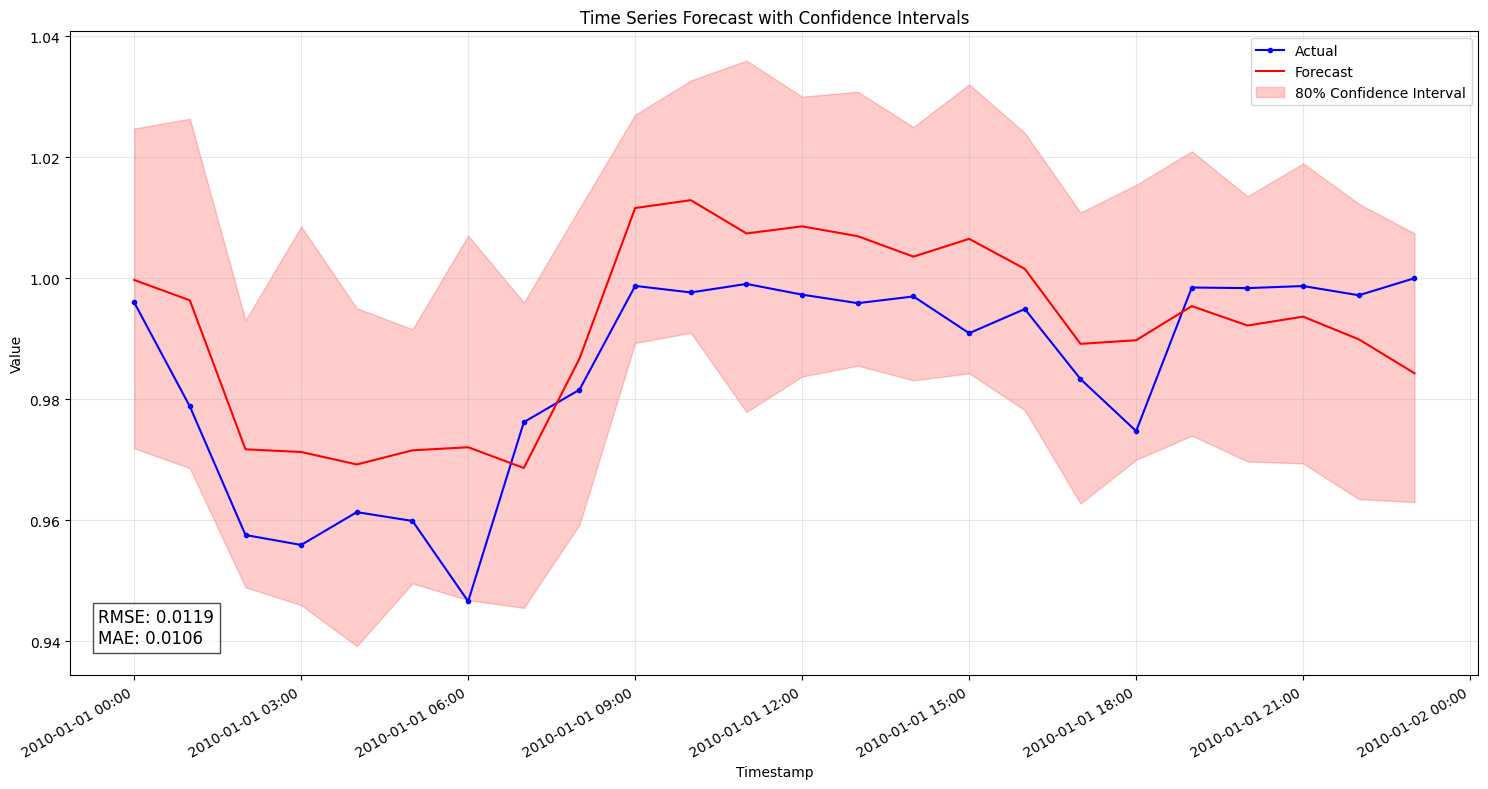

In [68]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats

# Assuming predictions_df is already created with columns:
# timestamp, actual, forecast, lower_bound, upper_bound

# 1. VISUALIZING FORECASTS WITH CONFIDENCE INTERVALS
def plot_forecast_with_intervals(df, title="Time Series Forecast with Confidence Intervals", 
                                figsize=(15, 8), sample_size=None):
    """
    Plot the time series forecast with actual values and confidence intervals.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the forecasts with columns: timestamp, actual, forecast, lower_bound, upper_bound
    title : str
        Title of the plot
    figsize : tuple
        Figure size (width, height)
    sample_size : int, optional
        Number of data points to show (most recent). If None, show all data.
    """
    # Create a copy to avoid modifying the original
    plot_df = df.copy()
    
    # Set timestamp as index if it's not already
    if 'timestamp' in plot_df.columns:
        plot_df.set_index('timestamp', inplace=True)
    
    # Sample the most recent data points if specified
    if sample_size is not None:
        plot_df = plot_df.iloc[-sample_size:]
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot actual values
    ax.plot(plot_df.index, plot_df['actual'], label='Actual', color='blue', marker='o', markersize=3, linestyle='-')
    
    # Plot forecast values
    ax.plot(plot_df.index, plot_df['forecast'], label='Forecast', color='red', linestyle='-')
    
    # Plot confidence intervals
    ax.fill_between(plot_df.index, plot_df['lower_bound'], plot_df['upper_bound'], 
                    color='red', alpha=0.2, label='80% Confidence Interval')
    
    # Format x-axis to display dates nicely
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    fig.autofmt_xdate()
    
    # Add labels and legend
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Value')
    ax.set_title(title)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Compute forecast error statistics
    mse = np.mean((plot_df['actual'] - plot_df['forecast'])**2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(plot_df['actual'] - plot_df['forecast']))
    
    # Add text with error metrics
    ax.text(0.02, 0.05, f'RMSE: {rmse:.4f}\nMAE: {mae:.4f}', 
            transform=ax.transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.7))
    
    plt.tight_layout()
    return fig, ax


    # Calculate grid dimensions
    n_series = len(series_ids)
    n_cols = min(2, n_series)
    n_rows = (n_series + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, sharex=True)
    if n_series == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    for i, series_id in enumerate(series_ids):
        # Filter data for this series
        series_df = df[df[id_column] == series_id].copy()
        series_df.set_index(timestamp_col, inplace=True)
        
        # Plot on the corresponding subplot
        ax = axes[i]
        
        # Plot actual values
        ax.plot(series_df.index, series_df[actual_col], label='Actual', color='blue', marker='o', markersize=3, linestyle='-')
        
        # Plot forecast values
        ax.plot(series_df.index, series_df[forecast_col], label='Forecast', color='red', linestyle='-')
        
        # Plot confidence intervals
        ax.fill_between(series_df.index, series_df[lower_col], series_df[upper_col], 
                        color='red', alpha=0.2, label='80% Confidence Interval')
        
        # Format x-axis
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        
        # Add title and grid
        ax.set_title(f'Series: {series_id}')
        ax.grid(True, alpha=0.3)
        
        # Add legend to only the first subplot
        if i == 0:
            ax.legend()
    
    # Hide any unused subplots
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    fig.autofmt_xdate()
    return fig, axes

# Example usage
# For a single series
fig, ax = plot_forecast_with_intervals(predictions_df, sample_size=48)  # Show last 48 hours
plt.show()

# If you have multiple series identified by a column (uncomment if needed)
# series_ids = predictions_df['series_id'].unique()[:4]  # Plot first 4 series
# fig, axes = plot_multiple_series(predictions_df, series_ids, id_column='series_id')
# plt.show()

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# 2. ANALYZING PATTERNS AND ANOMALIES IN TIME SERIES DATA

def decompose_time_series(df, column='actual', period=24, model='additive', figsize=(15, 12)):
    """
    Decompose time series into trend, seasonal, and residual components.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with time series data
    column : str
        Column name of the data to decompose
    period : int
        Period of the seasonality (e.g., 24 for hourly data with daily seasonality)
    model : str
        'additive' or 'multiplicative'
    figsize : tuple
        Figure size
        
    Returns:
    --------
    result : statsmodels.tsa.seasonal.DecomposeResult
        Decomposition result object
    """
    # Create a copy and ensure index is datetime
    ts_df = df.copy()
    if 'timestamp' in ts_df.columns:
        ts_df.set_index('timestamp', inplace=True)
    
    # Fill any missing values
    ts_df[column] = ts_df[column].interpolate()
    
    # Decompose the time series
    result = seasonal_decompose(ts_df[column], model=model, period=period)
    
    # Plot the decomposition
    fig, axes = plt.subplots(4, 1, figsize=figsize, sharex=True)
    
    # Original
    axes[0].plot(result.observed)
    axes[0].set_title('Original Time Series')
    axes[0].grid(True, alpha=0.3)
    
    # Trend
    axes[1].plot(result.trend)
    axes[1].set_title('Trend Component')
    axes[1].grid(True, alpha=0.3)
    
    # Seasonal
    axes[2].plot(result.seasonal)
    axes[2].set_title('Seasonal Component')
    axes[2].grid(True, alpha=0.3)
    
    # Residual
    axes[3].plot(result.resid)
    axes[3].set_title('Residual Component')
    axes[3].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    return result

def detect_anomalies(df, column='actual', window_size=24, threshold=3.0, figsize=(15, 8)):
    """
    Detect anomalies in time series data using a rolling Z-score method.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with time series data
    column : str
        Column name of the data to analyze
    window_size : int
        Size of the rolling window
    threshold : float
        Z-score threshold for anomaly detection
    figsize : tuple
        Figure size
        
    Returns:
    --------
    anomalies_df : pandas.DataFrame
        DataFrame with anomalies flagged
    """
    # Create a copy and ensure index is datetime
    ts_df = df.copy()
    if 'timestamp' in ts_df.columns:
        ts_df.set_index('timestamp', inplace=True)
    
    # Fill missing values
    ts_df[column] = ts_df[column].interpolate()
    
    # Calculate rolling statistics
    rolling_mean = ts_df[column].rolling(window=window_size).mean()
    rolling_std = ts_df[column].rolling(window=window_size).std()
    
    # Calculate Z-scores
    z_scores = (ts_df[column] - rolling_mean) / rolling_std
    
    # Identify anomalies
    ts_df['z_score'] = z_scores
    ts_df['is_anomaly'] = np.abs(z_scores) > threshold
    ts_df['anomaly_value'] = ts_df[column].where(ts_df['is_anomaly'])
    
    # Plot the data with anomalies highlighted
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot original data
    ax.plot(ts_df.index, ts_df[column], label='Original Data', color='blue')
    
    # Plot anomalies
    anomalies = ts_df[ts_df['is_anomaly']]
    ax.scatter(anomalies.index, anomalies[column], color='red', label='Anomalies', s=50)
    
    # Add rolling mean and bounds
    ax.plot(ts_df.index, rolling_mean, color='green', label='Rolling Mean', linestyle='--')
    ax.plot(ts_df.index, rolling_mean + threshold * rolling_std, color='orange', 
            label=f'Threshold (±{threshold} σ)', linestyle=':')
    ax.plot(ts_df.index, rolling_mean - threshold * rolling_std, color='orange', linestyle=':')
    
    # Format plot
    ax.set_title(f'Anomaly Detection (Z-score method, window={window_size}, threshold={threshold})')
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Value')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    fig.autofmt_xdate()
    plt.tight_layout()
    
    # Count anomalies
    anomaly_count = ts_df['is_anomaly'].sum()
    print(f"Detected {anomaly_count} anomalies ({anomaly_count/len(ts_df)*100:.2f}% of data points)")
    
    return ts_df

def analyze_forecast_errors(df, actual_col='actual', forecast_col='forecast', figsize=(15, 10)):
    """
    Analyze the forecast errors for patterns and anomalies.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with actual and forecast values
    actual_col, forecast_col : str
        Column names for actual and forecast values
    figsize : tuple
        Figure size
    """
    # Create a copy and ensure index is datetime
    error_df = df.copy()
    if 'timestamp' in error_df.columns:
        error_df.set_index('timestamp', inplace=True)
    
    # Calculate error metrics
    error_df['error'] = error_df[actual_col] - error_df[forecast_col]
    error_df['abs_error'] = np.abs(error_df['error'])
    error_df['squared_error'] = error_df['error'] ** 2
    error_df['pct_error'] = error_df['error'] / error_df[actual_col] * 100
    
    # Create figure with 3 subplots
    fig, axes = plt.subplots(3, 1, figsize=figsize, sharex=True)
    
    # Plot 1: Error over time
    axes[0].plot(error_df.index, error_df['error'], color='blue')
    axes[0].axhline(y=0, color='red', linestyle='--')
    axes[0].set_title('Forecast Error Over Time')
    axes[0].set_ylabel('Error')
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Error distribution
    sns.histplot(error_df['error'].dropna(), kde=True, ax=axes[1])
    axes[1].set_title('Error Distribution')
    axes[1].set_xlabel('Error')
    axes[1].set_ylabel('Frequency')
    
    # Plot 3: Scatter plot of actual vs forecast
    axes[2].scatter(error_df[actual_col], error_df[forecast_col], alpha=0.5)
    min_val = min(error_df[actual_col].min(), error_df[forecast_col].min())
    max_val = max(error_df[actual_col].max(), error_df[forecast_col].max())
    axes[2].plot([min_val, max_val], [min_val, max_val], 'r--')
    axes[2].set_title('Actual vs Forecast')
    axes[2].set_xlabel('Actual')
    axes[2].set_ylabel('Forecast')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Calculate and print error statistics
    mae = error_df['abs_error'].mean()
    mse = error_df['squared_error'].mean()
    rmse = np.sqrt(mse)
    mape = np.abs(error_df['pct_error']).mean()
    
    print(f"Error Statistics:")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.2f}%")
    
    # Check for autocorrelation in errors
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
    plot_acf(error_df['error'].dropna(), ax=ax1, lags=48)
    plot_pacf(error_df['error'].dropna(), ax=ax2, lags=48)
    ax1.set_title('Autocorrelation of Errors')
    ax2.set_title('Partial Autocorrelation of Errors')
    plt.tight_layout()
    
    return error_df

def identify_pattern_changes(df, column='actual', window_size=24, method='rolling_std', figsize=(15, 8)):
    """
    Identify changes in time series patterns using rolling statistics.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with time series data
    column : str
        Column name of the data to analyze
    window_size : int
        Size of the rolling window
    method : str
        Method to use ('rolling_std', 'rolling_entropy')
    figsize : tuple
        Figure size
    """
    # Create a copy and ensure index is datetime
    ts_df = df.copy()
    if 'timestamp' in ts_df.columns:
        ts_df.set_index('timestamp', inplace=True)
    
    # Fill missing values
    ts_df[column] = ts_df[column].interpolate()
    
    # Calculate rolling standard deviation
    if method == 'rolling_std':
        ts_df['pattern_metric'] = ts_df[column].rolling(window=window_size).std()
        metric_name = 'Rolling Standard Deviation'
    else:
        # Use DBSCAN to detect pattern changes
        scaler = StandardScaler()
        
        # Create a feature matrix with the value and its lags
        n_lags = min(10, window_size)
        feature_matrix = []
        for i in range(n_lags, len(ts_df)):
            feature_matrix.append(ts_df[column].iloc[i-n_lags:i].values)
        
        if len(feature_matrix) > 0:
            X = np.array(feature_matrix)
            X_scaled = scaler.fit_transform(X)
            
            # Cluster with DBSCAN
            clustering = DBSCAN(eps=0.5, min_samples=5).fit(X_scaled)
            
            # Add cluster labels
            ts_df['cluster'] = -1
            ts_df['cluster'].iloc[n_lags:] = clustering.labels_
            
            # Plot
            fig, ax = plt.subplots(figsize=figsize)
            scatter = ax.scatter(ts_df.index, ts_df[column], c=ts_df['cluster'], cmap='viridis', s=30)
            
            # Add legend
            legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
            ax.add_artist(legend1)
            
            ax.set_title('Pattern Changes Detected with DBSCAN Clustering')
            ax.set_xlabel('Timestamp')
            ax.set_ylabel('Value')
            ax.grid(True, alpha=0.3)
            
            fig.autofmt_xdate()
            plt.tight_layout()
            
            # Count the number of different patterns
            pattern_count = len(np.unique(clustering.labels_))
            print(f"Detected {pattern_count} different patterns in the time series")
            
            return ts_df
    
    # Plot the original data and the pattern metric
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, sharex=True)
    
    # Plot original data
    ax1.plot(ts_df.index, ts_df[column], label='Original Data', color='blue')
    ax1.set_title('Original Time Series')
    ax1.set_ylabel('Value')
    ax1.grid(True, alpha=0.3)
    
    # Plot pattern metric
    ax2.plot(ts_df.index, ts_df['pattern_metric'], label=metric_name, color='green')
    ax2.set_title(f'{metric_name} (window={window_size})')
    ax2.set_xlabel('Timestamp')
    ax2.set_ylabel('Variability')
    ax2.grid(True, alpha=0.3)
    
    fig.autofmt_xdate()
    plt.tight_layout()
    
    return ts_df

# Example usage
# Decompose the time series to understand patterns
result = decompose_time_series(predictions_df, column='actual', period=24)

# Detect anomalies in the actual values
anomalies_df = detect_anomalies(predictions_df, column='actual', window_size=24, threshold=3.0)

# Analyze forecast errors
error_analysis = analyze_forecast_errors(predictions_df)

# Identify pattern changes
pattern_changes = identify_pattern_changes(predictions_df, column='actual', window_size=24)

# You can also analyze the residuals from the decomposition for more subtle anomalies
residuals_df = pd.DataFrame(result.resid)
residuals_df.columns = ['residual']
residual_anomalies = detect_anomalies(residuals_df, column='residual', window_size=24, threshold=2.5)

ValueError: x must have 2 complete cycles requires 48 observations. x only has 24 observation(s)